In [1]:
import sys
import os
import pandas as pd
import numpy as np
import configparser
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import precision_recall_curve, roc_curve, auc
import matplotlib.pyplot as plt
import lightgbm as lgb
import lightgbm as lgb
from plotnine import ggplot, aes, geom_boxplot, labs, scale_color_manual, geom_point


project_root = "/home/dan1dr/zrive-ds-4q24-churn"

# Define the project root path
current_wd = os.getcwd()

# Change the working directory if necessary
if current_wd != project_root:
    print(f"Changing working directory from {current_wd} to {project_root}")
    os.chdir(project_root)
else:
    print("Already in the correct path")

# Add 'src' directory to sys.path
src_path = os.path.join(project_root, "src")
if src_path not in sys.path:
    print(f"Adding {src_path} to sys.path")
    sys.path.insert(0, src_path)

# Import the modules
from db_connectors.bigquery_service import BigqueryService
from data_gathering import data_gathering
from utils.logger import get_logger
from data_cleaning import data_cleaning
from feature_computation import feature_computation
from evaluation import evaluation

config = configparser.ConfigParser()
config.read("src/params.ini")

logger = get_logger(__name__)

Changing working directory from /home/dan1dr/zrive-ds-4q24-churn/src/eda to /home/dan1dr/zrive-ds-4q24-churn
Adding /home/dan1dr/zrive-ds-4q24-churn/src to sys.path


In [2]:
import configparser
from data_gathering import data_gathering
from data_cleaning import data_cleaning
from feature_computation import feature_computation
from modeling import modeling
from evaluation import evaluation
from utils.logger import get_logger


# Instantiate logger
logger = get_logger(__name__)


def get_initial_params():
    """
    Loads all relevant parameters into a global variable. These parameters are then accessible to other functions in the script.
    Each function can consume the parameters it requires for its operation.
    This approach ensures centralized management and consistency of parameters across different functions.

    Returns:
        None: This function does not return a value but populates a global variable
        with necessary parameters.
    """
    global train_from, train_to, end_date, logistic_regression_params, lightgbm_params

    config = configparser.ConfigParser()
    config.read("src/params.ini")

    train_from = config.get("PARAMS", "train_from")
    train_to = config.get("PARAMS", "train_to")
    end_date = config.get("PARAMS", "end_date")
    # Load Logistic Regression parameters
    logistic_regression_params = {
        "penalty": config.get("LOGISTIC_REGRESSION", "penalty", fallback="l2"),
        "C": config.getfloat("LOGISTIC_REGRESSION", "C", fallback=1.0),
        "solver": config.get("LOGISTIC_REGRESSION", "solver", fallback="saga"),
        "max_iter": config.getint("LOGISTIC_REGRESSION", "max_iter", fallback=10000),
    }

    # Load LightGBM parameters
    lightgbm_params = {
        "boosting_type": config.get("LIGHTGBM", "boosting_type", fallback="gbdt"),
        "num_leaves": config.getint("LIGHTGBM", "num_leaves", fallback=12),
        "max_depth": config.getint("LIGHTGBM", "max_depth", fallback=-1),
        "learning_rate": config.getfloat("LIGHTGBM", "learning_rate", fallback=0.005),
        "n_estimators": config.getint("LIGHTGBM", "n_estimators", fallback=100),
        "random_state": config.getint("LIGHTGBM", "random_state", fallback=500),
        "colsample_bytree": config.getfloat(
            "LIGHTGBM", "colsample_bytree", fallback=0.64
        ),
        "subsample": config.getfloat("LIGHTGBM", "subsample", fallback=0.7),
        "reg_alpha": config.getint("LIGHTGBM", "reg_alpha", fallback=0),
        "reg_lambda": config.getint("LIGHTGBM", "reg_lambda", fallback=1),
    }

In [3]:
get_initial_params()
save_curves_path = "src/models"
save_features_path = "src/features"
save_target_path = "src/target"


In [7]:
query = """
WITH selectable_customer AS (
    SELECT customer_id
    FROM `mm-bi-catedras-upm.ESTIMACION_CHURN.multibrand_monthly_customer_base_mp2023_1`
    GROUP BY customer_id
), 

customer_selected AS (
    SELECT customer_id AS selected_customer
    FROM   selectable_customer
    WHERE  MOD(ABS(FARM_FINGERPRINT(CAST(customer_id AS STRING))), 10) = 0
)

SELECT *
FROM `mm-bi-catedras-upm.ESTIMACION_CHURN.multibrand_monthly_customer_base_mp2023_1`
INNER JOIN customer_selected
ON customer_id = selected_customer
WHERE IS_CUST_SEGM_RESI > 0
AND IS_CUST_BILL_POST_CURR = TRUE
AND CUST_BUNDLE_CURR = 'FMC'
AND NUM_IMPAGOS = 0
AND pago_final_0 IS NOT NULL
"""

INFO - Started querying data
INFO - Data succesfully retrieved! Length: 224482
INFO - Starting cleaning data
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Dropping column Import_Rest_quota_disp
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO 

[LightGBM] [Info] Number of positive: 696, number of negative: 19273
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.064297 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 66648
[LightGBM] [Info] Number of data points in the train set: 19969, number of used features: 343
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.034854 -> initscore=-3.321111
[LightGBM] [Info] Start training from score -3.321111


INFO - Completed model training!
INFO - Started evaluation for Pipeline(steps=[('lightgbm',
                 LGBMClassifier(colsample_bytree=0.64, learning_rate=0.005,
                                num_leaves=12, random_state=500, reg_alpha=0,
                                reg_lambda=1, subsample=0.7))])
INFO - Generating plots


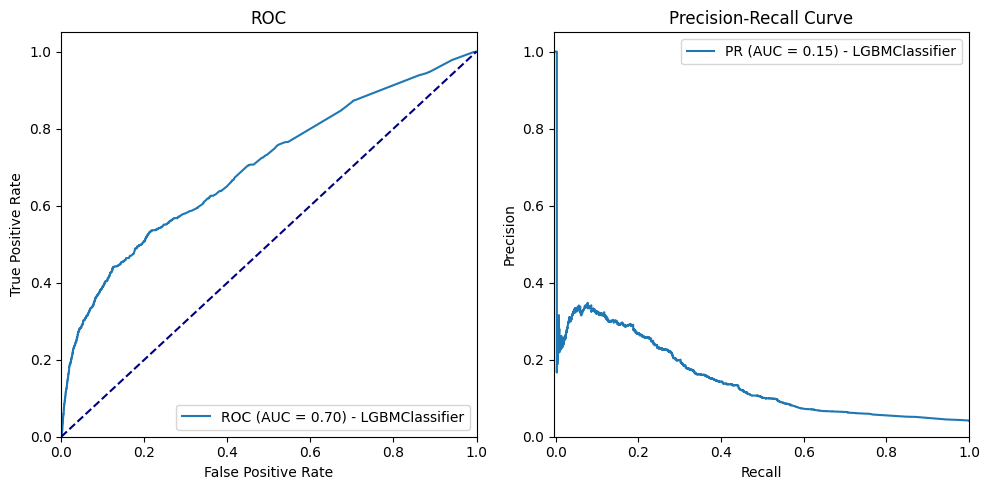

INFO - Precision in the first decile: 0.16
/home/dan1dr/zrive-ds-4q24-churn/src/evaluation.py:105: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
INFO - Uplift by decile:
INFO - decile
0    3.706230
1    1.256801
2    0.780691
3    0.670080
4    0.866585
5    0.674670
6    0.656280
7    0.676082
8    0.416807
9    0.478019
Name: y_true, dtype: float64
INFO - Completed evaluation!
INFO - Feature importance
INFO -                                 Feature  Coefficient
76                        NUM_DISC_CURR           70
43                   MAX_DAYS_PERM_CURR           66
164  service_fix_pending_install_3month           60
182           aperiodica_0_avg_3_months           52
131       cust_days_since_last_mob_port           52
188            periodica_0_avg_6_months           30
141           dif_pago_f

In [8]:
get_initial_params()
raw_data = data_gathering(query, logger)
clean_data = data_cleaning(raw_data, logger)
features, target, features_test, target_test = feature_computation(
    clean_data,
    train_from,
    train_to,
    logger,
    save_features_path=save_features_path,
    save_target_path=save_target_path,
)
model = modeling(features, target, lightgbm_params, logger)
model_metrics, precision_decile, uplift_by_decile, feature_importance = evaluation(
    model, features_test, target_test, logger, save_curves_path
)

In [12]:
query = """
WITH selectable_customer_2022 AS (
    SELECT customer_id
    FROM `mm-bi-catedras-upm.ESTIMACION_CHURN.multibrand_monthly_customer_base_mp2022`
    GROUP BY customer_id
), 
customer_selected_2022 AS (
    SELECT customer_id AS selected_customer_2022
    FROM selectable_customer_2022
    WHERE MOD(ABS(FARM_FINGERPRINT(CAST(customer_id AS STRING))), 100) = 0
),
selectable_customer_2023 AS (
    SELECT customer_id
    FROM `mm-bi-catedras-upm.ESTIMACION_CHURN.multibrand_monthly_customer_base_mp2023_1`
    GROUP BY customer_id
), 
customer_selected_2023 AS (
    SELECT customer_id AS selected_customer_2023
    FROM selectable_customer_2023
    WHERE MOD(ABS(FARM_FINGERPRINT(CAST(customer_id AS STRING))), 100) = 0
),
churned_users AS (
    SELECT selected_customer_2022 AS customer_id
    FROM customer_selected_2022
    WHERE selected_customer_2022 NOT IN (SELECT selected_customer_2023 FROM customer_selected_2023)
),
combined_data AS (
    SELECT 
        2022 AS YEAR,
        cs2022.selected_customer_2022 AS customer_id,
        base2022.*,
        CASE 
            WHEN cs2022.selected_customer_2022 IN (SELECT customer_id FROM churned_users) 
            THEN TRUE 
            ELSE FALSE 
        END AS is_churned
    FROM customer_selected_2022 cs2022
    JOIN `mm-bi-catedras-upm.ESTIMACION_CHURN.multibrand_monthly_customer_base_mp2022` base2022
    ON cs2022.selected_customer_2022 = base2022.customer_id

    UNION ALL

    SELECT 
        2023 AS YEAR,
        cs2023.selected_customer_2023 AS customer_id,
        base2023.*,
        FALSE AS is_churned
    FROM customer_selected_2023 cs2023
    JOIN `mm-bi-catedras-upm.ESTIMACION_CHURN.multibrand_monthly_customer_base_mp2023_1` base2023
    ON cs2023.selected_customer_2023 = base2023.customer_id
)

SELECT *
FROM combined_data
WHERE IS_CUST_SEGM_RESI > 0
AND IS_CUST_BILL_POST_CURR = TRUE
AND CUST_BUNDLE_CURR = 'FMC'
AND NUM_IMPAGOS = 0
AND pago_final_0 IS NOT NULL
"""

INFO - Started querying data
INFO - Data succesfully retrieved! Length: 52946
INFO - Starting cleaning data
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Dropping column Import_Rest_quota_disp
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO -

[LightGBM] [Info] Number of positive: 31, number of negative: 1428
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005055 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60681
[LightGBM] [Info] Number of data points in the train set: 1459, number of used features: 328
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.021247 -> initscore=-3.830043
[LightGBM] [Info] Start training from score -3.830043


INFO - Completed model training!
INFO - Started evaluation for Pipeline(steps=[('lightgbm',
                 LGBMClassifier(colsample_bytree=0.64, learning_rate=0.005,
                                num_leaves=12, random_state=500, reg_alpha=0,
                                reg_lambda=1, subsample=0.7))])
INFO - Generating plots


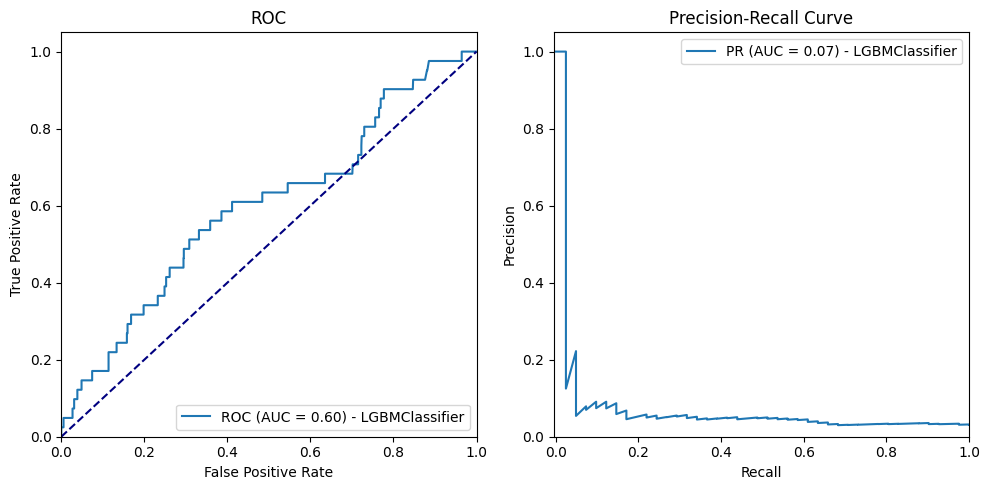

INFO - Precision in the first decile: 0.05
/home/dan1dr/zrive-ds-4q24-churn/src/evaluation.py:105: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
INFO - Uplift by decile:
INFO - decile
0    1.697124
1    1.465615
2    1.465615
3    1.221346
4    0.488538
5    0.244269
6    0.244269
7    2.198423
8    0.825961
9    0.218039
Name: y_true, dtype: float64
INFO - Completed evaluation!
INFO - Feature importance
INFO -                                        Feature  Coefficient
339         NUM_SECS_WEEKEND_CURR_std_3_months           51
43                          MAX_DAYS_PERM_CURR           42
262   PERC_SECS_TYPE_IN_OWNN_CURR_avg_3_months           35
107                         NUM_NETW_RAAS_CURR           31
349              NUM_CALL_WEEKEND_std_3_months           29
65                 NUM_CALL_TYPE_OU

[LightGBM] [Info] Number of positive: 41, number of negative: 1291
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004475 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60737
[LightGBM] [Info] Number of data points in the train set: 1332, number of used features: 321
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.030781 -> initscore=-3.449600
[LightGBM] [Info] Start training from score -3.449600


INFO - Completed model training!
INFO - Started evaluation for Pipeline(steps=[('lightgbm',
                 LGBMClassifier(colsample_bytree=0.64, learning_rate=0.005,
                                num_leaves=12, random_state=500, reg_alpha=0,
                                reg_lambda=1, subsample=0.7))])
INFO - Generating plots


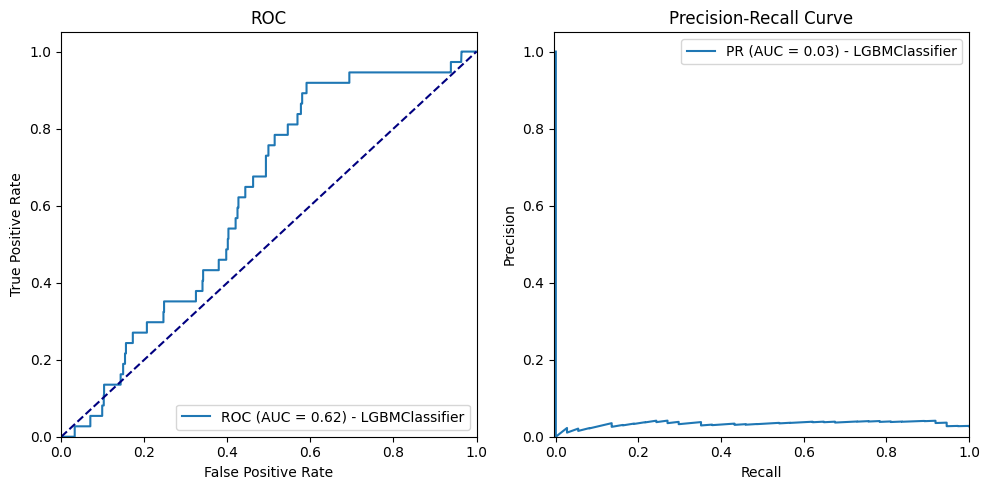

INFO - Precision in the first decile: 0.02
/home/dan1dr/zrive-ds-4q24-churn/src/evaluation.py:105: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
INFO - Uplift by decile:
INFO - decile
0    0.808443
1    1.900238
2    0.808443
3    1.357313
4    2.425330
5    1.900238
6    0.000000
7    0.271463
8    0.000000
9    0.538962
Name: y_true, dtype: float64
INFO - Completed evaluation!
INFO - Feature importance
INFO -                                       Feature  Coefficient
294           NUM_NETW_OWNN_CURR_std_3_months           53
3                                 periodica_0           42
175                 pago_final_0_std_6_months           29
38                         MIN_DAYS_PERM_CURR           29
276   PERC_SECS_TYPE_OUT_NATR_CURR_prev_month           27
306        PERC_CALL_TYPE_OUT_CURR_prev_m

[LightGBM] [Info] Number of positive: 37, number of negative: 1329
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006514 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60629
[LightGBM] [Info] Number of data points in the train set: 1366, number of used features: 321
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.027086 -> initscore=-3.581264
[LightGBM] [Info] Start training from score -3.581264


INFO - Completed model training!
INFO - Started evaluation for Pipeline(steps=[('lightgbm',
                 LGBMClassifier(colsample_bytree=0.64, learning_rate=0.005,
                                num_leaves=12, random_state=500, reg_alpha=0,
                                reg_lambda=1, subsample=0.7))])
INFO - Generating plots


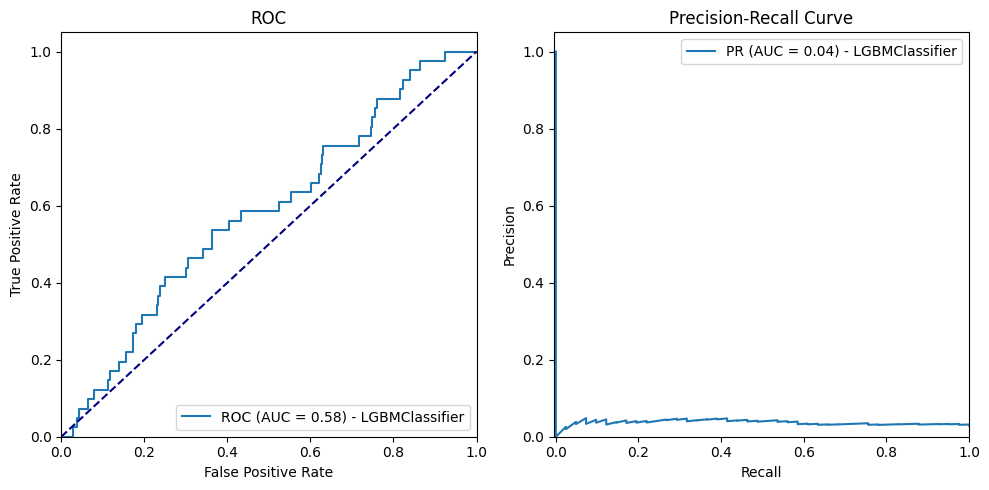

INFO - Precision in the first decile: 0.04
/home/dan1dr/zrive-ds-4q24-churn/src/evaluation.py:105: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
INFO - Uplift by decile:
INFO - decile
0    1.216899
1    1.947038
2    0.980523
3    1.216899
4    0.490261
5    0.486760
6    1.216899
7    1.225654
8    0.973519
9    0.243380
Name: y_true, dtype: float64
INFO - Completed evaluation!
INFO - Feature importance
INFO -                                       Feature  Coefficient
229                NUM_SESS_CURR_std_3_months           58
112                             NUM_PERM_CURR           51
179                    consumo_0_std_3_months           47
171                   pago_final_0_prev_month           38
315          PERC_CALL_OWNN_CURR_std_6_months           31
131             cust_days_since_last_mob_

[LightGBM] [Info] Number of positive: 41, number of negative: 1356
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005960 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60488
[LightGBM] [Info] Number of data points in the train set: 1397, number of used features: 322
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.029349 -> initscore=-3.498722
[LightGBM] [Info] Start training from score -3.498722


INFO - Completed model training!
INFO - Started evaluation for Pipeline(steps=[('lightgbm',
                 LGBMClassifier(colsample_bytree=0.64, learning_rate=0.005,
                                num_leaves=12, random_state=500, reg_alpha=0,
                                reg_lambda=1, subsample=0.7))])
INFO - Generating plots


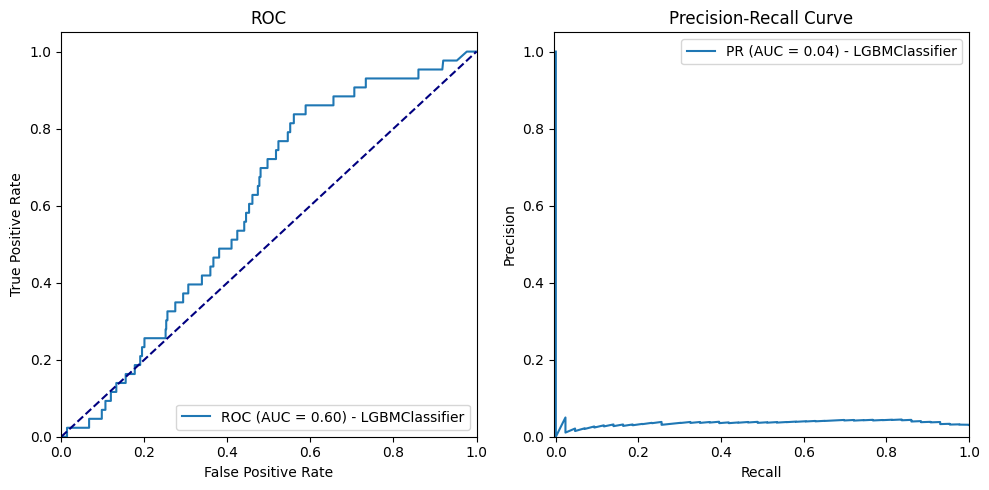

INFO - Precision in the first decile: 0.02
/home/dan1dr/zrive-ds-4q24-churn/src/evaluation.py:105: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
INFO - Uplift by decile:
INFO - decile
0    0.695709
1    1.634834
2    1.391418
3    1.167739
4    2.087127
5    1.634834
6    0.231903
7    0.467095
8    0.236908
9    0.454210
Name: y_true, dtype: float64
INFO - Completed evaluation!
INFO - Feature importance
INFO -                                       Feature  Coefficient
191                     discount_0_prev_month           68
264  PERC_SECS_TYPE_IN_OWNN_CURR_std_3_months           51
300                NUM_CALL_CURR_std_6_months           41
172                 pago_final_0_avg_3_months           32
152                dif_periodica_prev_3_month           28
65                NUM_CALL_TYPE_OUT_OWNN_

[LightGBM] [Info] Number of positive: 43, number of negative: 1373
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007139 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60591
[LightGBM] [Info] Number of data points in the train set: 1416, number of used features: 323
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.030367 -> initscore=-3.463553
[LightGBM] [Info] Start training from score -3.463553


INFO - Completed model training!
INFO - Started evaluation for Pipeline(steps=[('lightgbm',
                 LGBMClassifier(colsample_bytree=0.64, learning_rate=0.005,
                                num_leaves=12, random_state=500, reg_alpha=0,
                                reg_lambda=1, subsample=0.7))])
INFO - Generating plots


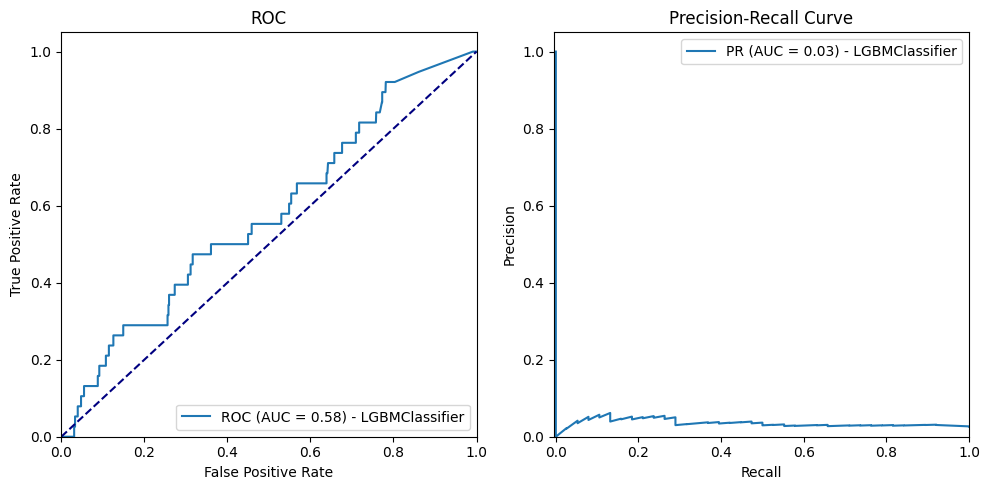

INFO - Precision in the first decile: 0.05
/home/dan1dr/zrive-ds-4q24-churn/src/evaluation.py:105: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
INFO - Uplift by decile:
INFO - decile
0    1.835664
1    1.056338
2    1.048951
3    1.056338
4    0.528169
5    1.048951
6    1.056338
7    1.829268
8    0.340909
9    0.384615
Name: y_true, dtype: float64
INFO - Completed evaluation!
INFO - Feature importance
INFO -                                   Feature  Coefficient
19           PERC_SECS_TYPE_OUT_OWNN_CURR           61
336      NUM_SECS_WEEKEND_CURR_prev_month           55
314      PERC_CALL_OWNN_CURR_std_3_months           51
206             NUM_GB_2G_CURR_prev_month           31
294       NUM_NETW_OWNN_CURR_std_3_months           31
18            PERC_SECS_TYPE_IN_OWNN_CURR           30
112       

[LightGBM] [Info] Number of positive: 38, number of negative: 1387
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005490 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60516
[LightGBM] [Info] Number of data points in the train set: 1425, number of used features: 322
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.026667 -> initscore=-3.597312
[LightGBM] [Info] Start training from score -3.597312


INFO - Completed model training!
INFO - Started evaluation for Pipeline(steps=[('lightgbm',
                 LGBMClassifier(colsample_bytree=0.64, learning_rate=0.005,
                                num_leaves=12, random_state=500, reg_alpha=0,
                                reg_lambda=1, subsample=0.7))])
INFO - Generating plots


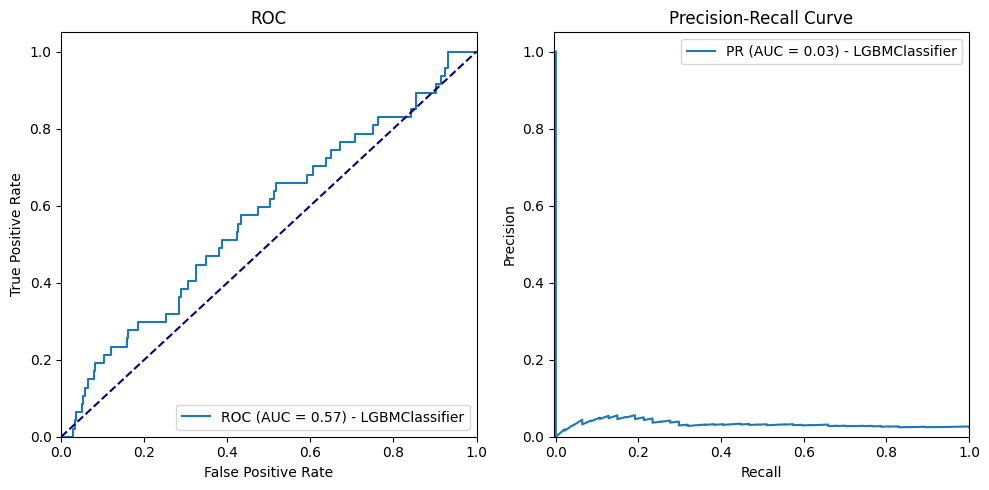

INFO - Precision in the first decile: 0.05
/home/dan1dr/zrive-ds-4q24-churn/src/evaluation.py:105: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
INFO - Uplift by decile:
INFO - decile
0    1.906831
1    1.064956
2    0.851964
3    1.277947
4    0.851964
5    0.851964
6    0.851964
7    0.638973
8    0.638973
9    1.059351
Name: y_true, dtype: float64
INFO - Completed evaluation!
INFO - Feature importance
INFO -                               Feature  Coefficient
10                     NUM_GB_5G_CURR           47
106                NUM_NETW_OSPN_CURR           44
230        NUM_SESS_CURR_std_6_months           41
45            MIN_PENALTY_AMOUNT_CURR           37
190          periodica_0_std_6_months           36
133    cust_max_days_between_mob_port           29
112                     NUM_PERM_CURR 

[LightGBM] [Info] Number of positive: 47, number of negative: 1845
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006505 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 61314
[LightGBM] [Info] Number of data points in the train set: 1892, number of used features: 328
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.024841 -> initscore=-3.670087
[LightGBM] [Info] Start training from score -3.670087


INFO - Completed model training!
INFO - Started evaluation for Pipeline(steps=[('lightgbm',
                 LGBMClassifier(colsample_bytree=0.64, learning_rate=0.005,
                                num_leaves=12, random_state=500, reg_alpha=0,
                                reg_lambda=1, subsample=0.7))])
INFO - Generating plots


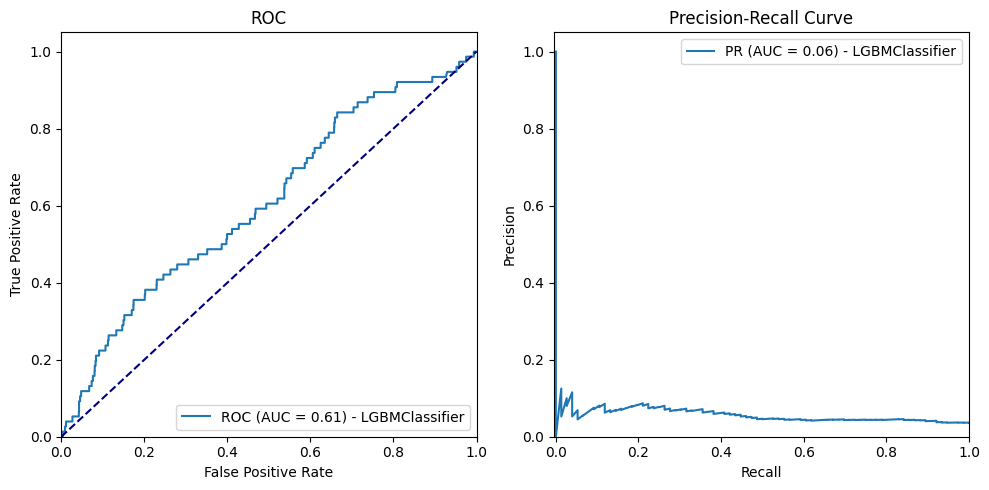

INFO - Precision in the first decile: 0.08
/home/dan1dr/zrive-ds-4q24-churn/src/evaluation.py:105: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
INFO - Uplift by decile:
INFO - decile
0    2.231491
1    1.318952
2    0.918849
3    0.527581
4    1.055162
5    1.181377
6    1.187057
7    0.525057
8    0.395686
9    0.656321
Name: y_true, dtype: float64
INFO - Completed evaluation!
INFO - Feature importance
INFO -                                       Feature  Coefficient
142               dif_pago_final_prev_2_month           66
76                              NUM_DISC_CURR           53
206                 NUM_GB_2G_CURR_prev_month           38
26                     PERC_CALL_TYPE_IN_CURR           34
27                    PERC_CALL_TYPE_OUT_CURR           32
100                NUM_MOB_PORT_LAST_6_MO

[LightGBM] [Info] Number of positive: 76, number of negative: 2009
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007284 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 61830
[LightGBM] [Info] Number of data points in the train set: 2085, number of used features: 328
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036451 -> initscore=-3.274659
[LightGBM] [Info] Start training from score -3.274659


INFO - Completed model training!
INFO - Started evaluation for Pipeline(steps=[('lightgbm',
                 LGBMClassifier(colsample_bytree=0.64, learning_rate=0.005,
                                num_leaves=12, random_state=500, reg_alpha=0,
                                reg_lambda=1, subsample=0.7))])
INFO - Generating plots


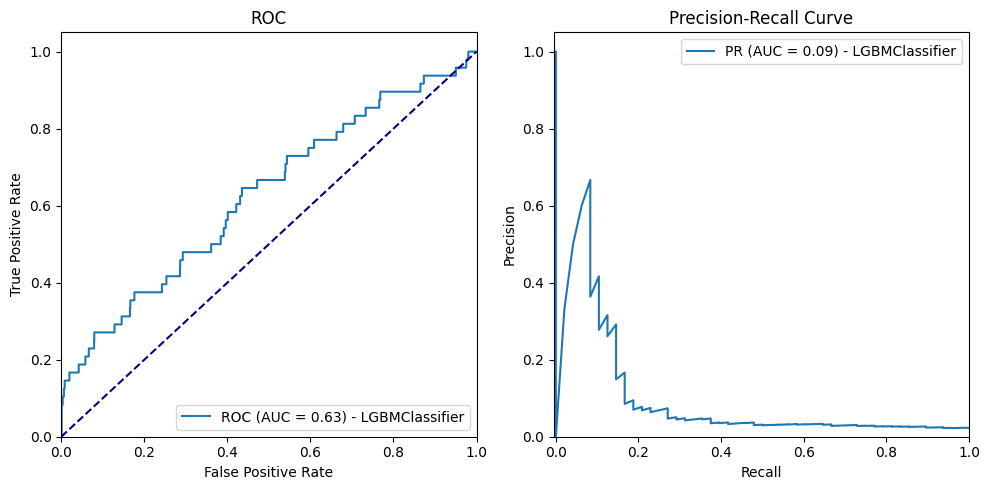

INFO - Precision in the first decile: 0.06
/home/dan1dr/zrive-ds-4q24-churn/src/evaluation.py:105: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
INFO - Uplift by decile:
INFO - decile
0    2.705754
1    1.040675
2    1.040675
3    0.836523
4    1.040675
5    0.832540
6    0.627392
7    0.832540
8    0.416270
9    0.624405
Name: y_true, dtype: float64
INFO - Completed evaluation!
INFO - Feature importance
INFO -                               Feature  Coefficient
152        dif_periodica_prev_3_month           67
112                     NUM_PERM_CURR           53
336  NUM_SECS_WEEKEND_CURR_prev_month           34
195           discount_0_std_6_months           32
0                        pago_final_0           31
76                      NUM_DISC_CURR           29
43                 MAX_DAYS_PERM_CURR 

[LightGBM] [Info] Number of positive: 48, number of negative: 2050
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008730 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 61760
[LightGBM] [Info] Number of data points in the train set: 2098, number of used features: 328
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.022879 -> initscore=-3.754394
[LightGBM] [Info] Start training from score -3.754394


INFO - Completed model training!
INFO - Started evaluation for Pipeline(steps=[('lightgbm',
                 LGBMClassifier(colsample_bytree=0.64, learning_rate=0.005,
                                num_leaves=12, random_state=500, reg_alpha=0,
                                reg_lambda=1, subsample=0.7))])
INFO - Generating plots


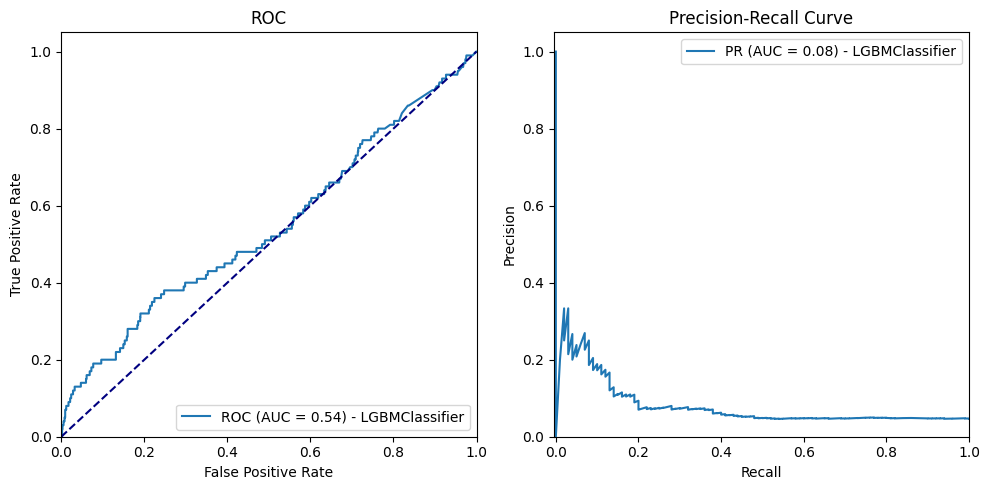

INFO - Precision in the first decile: 0.09
/home/dan1dr/zrive-ds-4q24-churn/src/evaluation.py:105: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
INFO - Uplift by decile:
INFO - decile
0    1.895519
1    1.303081
2    0.698349
3    0.601422
4    0.601422
5    0.997642
6    0.906429
7    1.146059
8    0.869178
9    0.988318
Name: y_true, dtype: float64
INFO - Completed evaluation!
INFO - Feature importance
INFO -                                  Feature  Coefficient
148            dif_discount_prev_2_month           59
250     PERC_SECS_OWNN_CURR_std_6_months           43
149            dif_discount_prev_3_month           39
70           NUM_CALL_TYPE_OUT_WEEK_CURR           33
133       cust_max_days_between_mob_port           32
305  PERC_CALL_TYPE_IN_CURR_std_6_months           31
38               

[LightGBM] [Info] Number of positive: 100, number of negative: 2015
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012422 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 62115
[LightGBM] [Info] Number of data points in the train set: 2115, number of used features: 328
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.047281 -> initscore=-3.003204
[LightGBM] [Info] Start training from score -3.003204


INFO - Completed model training!
INFO - Started evaluation for Pipeline(steps=[('lightgbm',
                 LGBMClassifier(colsample_bytree=0.64, learning_rate=0.005,
                                num_leaves=12, random_state=500, reg_alpha=0,
                                reg_lambda=1, subsample=0.7))])
INFO - Generating plots


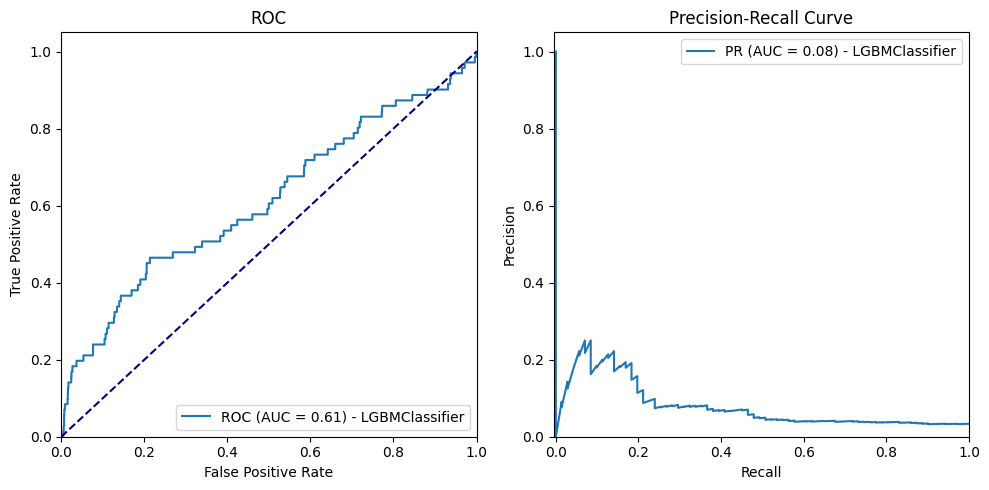

INFO - Precision in the first decile: 0.08
/home/dan1dr/zrive-ds-4q24-churn/src/evaluation.py:105: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
INFO - Uplift by decile:
INFO - decile
0    2.387590
1    1.693345
2    0.705560
3    0.561786
4    0.564448
5    1.270009
6    0.561786
7    0.846672
8    0.423336
9    0.983125
Name: y_true, dtype: float64
INFO - Completed evaluation!
INFO - Feature importance
INFO -                                 Feature  Coefficient
112                       NUM_PERM_CURR           54
152          dif_periodica_prev_3_month           47
143         dif_pago_final_prev_3_month           42
14              PERC_SECS_TYPE_OUT_CURR           38
148           dif_discount_prev_2_month           32
43                   MAX_DAYS_PERM_CURR           30
150            dif_perio

[LightGBM] [Info] Number of positive: 71, number of negative: 2043
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007399 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 61983
[LightGBM] [Info] Number of data points in the train set: 2114, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.033586 -> initscore=-3.359495
[LightGBM] [Info] Start training from score -3.359495


INFO - Completed model training!
INFO - Started evaluation for Pipeline(steps=[('lightgbm',
                 LGBMClassifier(colsample_bytree=0.64, learning_rate=0.005,
                                num_leaves=12, random_state=500, reg_alpha=0,
                                reg_lambda=1, subsample=0.7))])
INFO - Generating plots


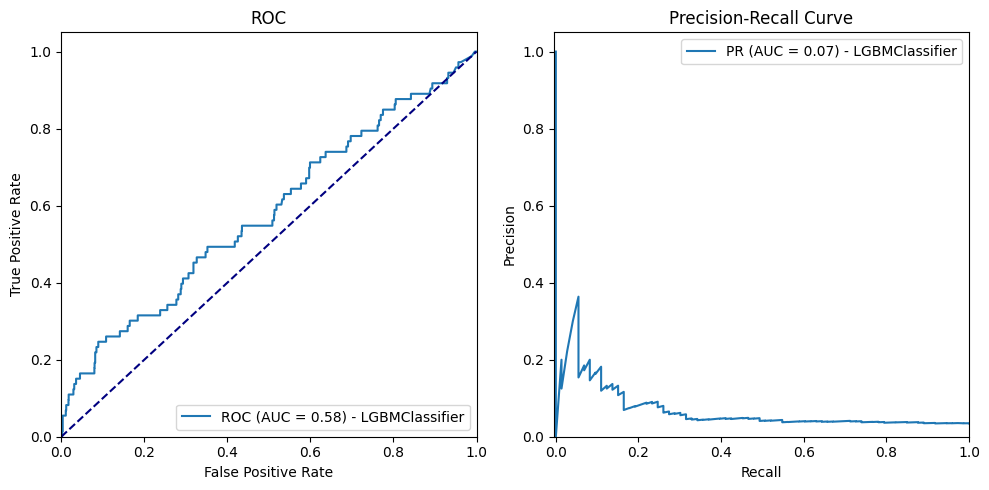

INFO - Precision in the first decile: 0.09
/home/dan1dr/zrive-ds-4q24-churn/src/evaluation.py:105: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
INFO - Uplift by decile:
INFO - decile
0    2.457534
1    0.685915
2    0.960281
3    0.823098
4    0.548732
5    1.234646
6    1.092237
7    0.685915
8    0.685915
9    0.819178
Name: y_true, dtype: float64
INFO - Completed evaluation!
INFO - Feature importance
INFO -                                      Feature  Coefficient
112                            NUM_PERM_CURR           68
345               NUM_CALL_WEEK_std_6_months           40
152               dif_periodica_prev_3_month           38
291            NUM_NETW_OWNN_CURR_prev_month           35
266  PERC_SECS_TYPE_OUT_OWNN_CURR_prev_month           33
285           NUM_PLAT_GMM_CURR_std_6_months   

[LightGBM] [Info] Number of positive: 73, number of negative: 2020
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008147 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 62005
[LightGBM] [Info] Number of data points in the train set: 2093, number of used features: 331
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.034878 -> initscore=-3.320393
[LightGBM] [Info] Start training from score -3.320393


INFO - Completed model training!
INFO - Started evaluation for Pipeline(steps=[('lightgbm',
                 LGBMClassifier(colsample_bytree=0.64, learning_rate=0.005,
                                num_leaves=12, random_state=500, reg_alpha=0,
                                reg_lambda=1, subsample=0.7))])
INFO - Generating plots


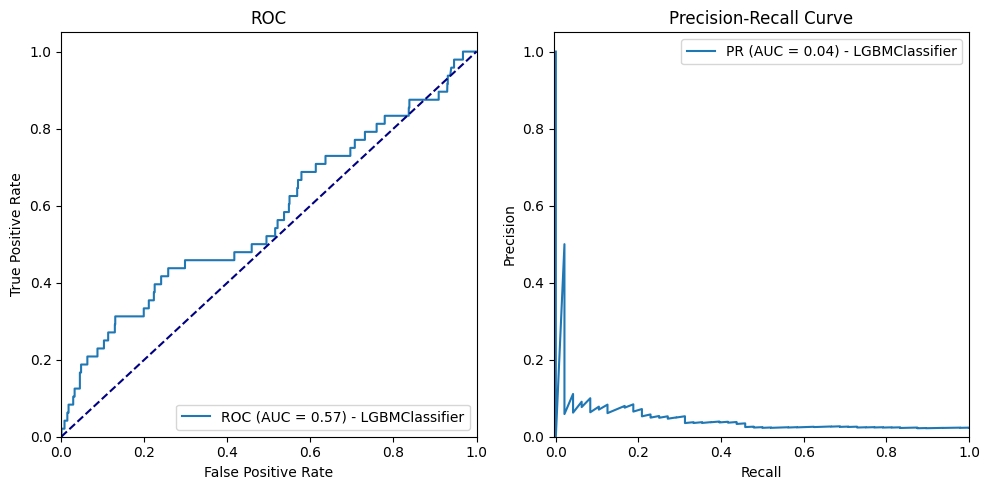

INFO - Precision in the first decile: 0.05
/home/dan1dr/zrive-ds-4q24-churn/src/evaluation.py:105: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
INFO - Uplift by decile:
INFO - decile
0    2.282978
1    0.834127
2    1.251190
3    0.208532
4    0.625595
5    1.668254
6    0.625595
7    0.834127
8    0.417063
9    1.245261
Name: y_true, dtype: float64
INFO - Completed evaluation!
INFO - Feature importance
INFO -                                       Feature  Coefficient
112                             NUM_PERM_CURR           68
38                         MIN_DAYS_PERM_CURR           59
209               NUM_GB_2G_CURR_std_3_months           48
329        NUM_CALL_WEEKEND_CURR_std_3_months           47
160               service_fix_pending_install           44
131             cust_days_since_last_mob_

[LightGBM] [Info] Number of positive: 48, number of negative: 2054
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007097 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 62170
[LightGBM] [Info] Number of data points in the train set: 2102, number of used features: 331
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.022835 -> initscore=-3.756343
[LightGBM] [Info] Start training from score -3.756343


INFO - Completed model training!
INFO - Started evaluation for Pipeline(steps=[('lightgbm',
                 LGBMClassifier(colsample_bytree=0.64, learning_rate=0.005,
                                num_leaves=12, random_state=500, reg_alpha=0,
                                reg_lambda=1, subsample=0.7))])
INFO - Generating plots


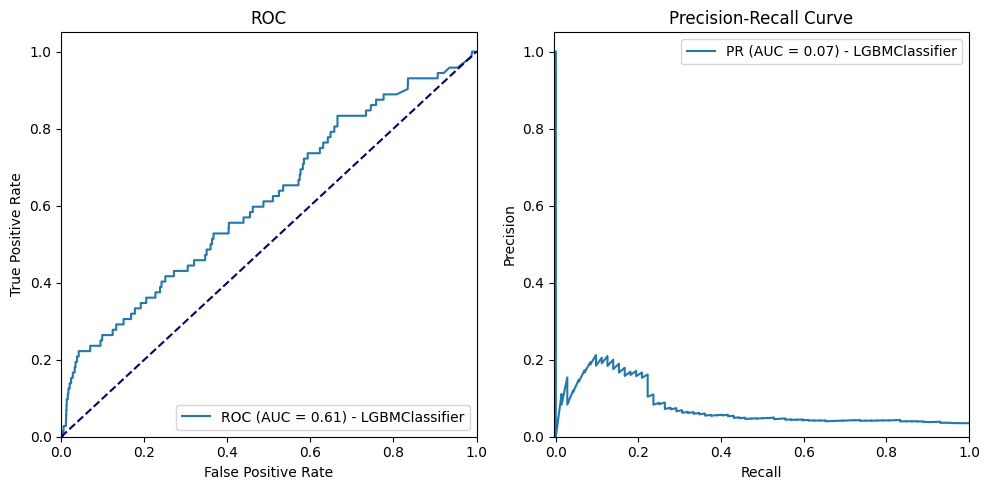

INFO - Precision in the first decile: 0.09
/home/dan1dr/zrive-ds-4q24-churn/src/evaluation.py:105: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
INFO - Uplift by decile:
INFO - decile
0    2.490291
1    0.973171
2    0.834146
3    0.973171
4    0.834146
5    1.251220
6    0.973171
7    0.556098
8    0.417073
9    0.691748
Name: y_true, dtype: float64
INFO - Completed evaluation!
INFO - Feature importance
INFO -                                       Feature  Coefficient
164        service_fix_pending_install_3month           67
182                 aperiodica_0_avg_3_months           58
345                NUM_CALL_WEEK_std_6_months           58
329        NUM_CALL_WEEKEND_CURR_std_3_months           46
43                         MAX_DAYS_PERM_CURR           42
274  PERC_SECS_TYPE_IN_NATR_CURR_std_3_mo

In [13]:
get_initial_params()
raw_data = data_gathering(query, logger)
clean_data = data_cleaning(raw_data, logger)

all_data = {}
last_train_period = pd.to_datetime(end_date) - pd.DateOffset(months=3)
train_from = pd.to_datetime(train_from)
train_to = pd.to_datetime(train_to)


while train_to <= last_train_period:

    logger.info(f"MODEL FOR {train_to}")

    str_train_from = train_from.strftime('%Y-%m-%d')
    str_train_to = train_to.strftime('%Y-%m-%d')

    features, target, features_test, target_test = feature_computation(
        clean_data, str_train_from, str_train_to, logger
    )
    logger.info(f"{type(train_from)}")
    model = modeling(features, target, lightgbm_params, logger)
    model_metrics, precision_decile, uplift_by_decile, feature_importance = evaluation(
    model, features_test, target_test, logger, save_curves_path)

    all_data[train_to.strftime('%Y-%m')] = {
        'features': features,
        'target': target,
        'features_test': features_test,
        'target_test': target_test,
        'model': model,
        'metrics': model_metrics,
        'precision_decile': precision_decile,
        'uplift_by_decile': uplift_by_decile,
        'feature_importance': feature_importance
    }
    #to-do pass directly datetimes into feature_computation and not use this here 

    train_from += pd.DateOffset(months=1)
    train_to += pd.DateOffset(months=1)


In [28]:
precision_first_decile_values = []
uplift_first_decile_values = []

for period in all_data:
    precision_first_decile_values.append(all_data[period]['precision_decile'])
    uplift_first_decile_values.append(all_data[period]['uplift_by_decile'][0])

periods = list(all_data.keys())

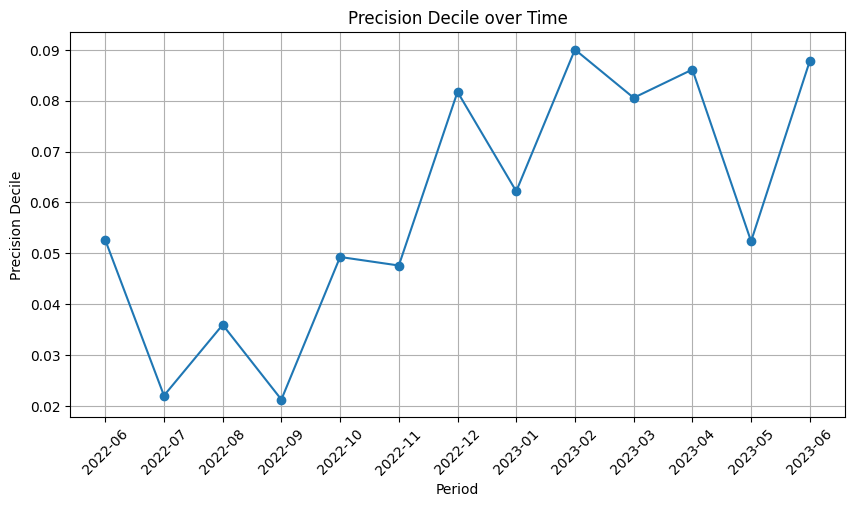

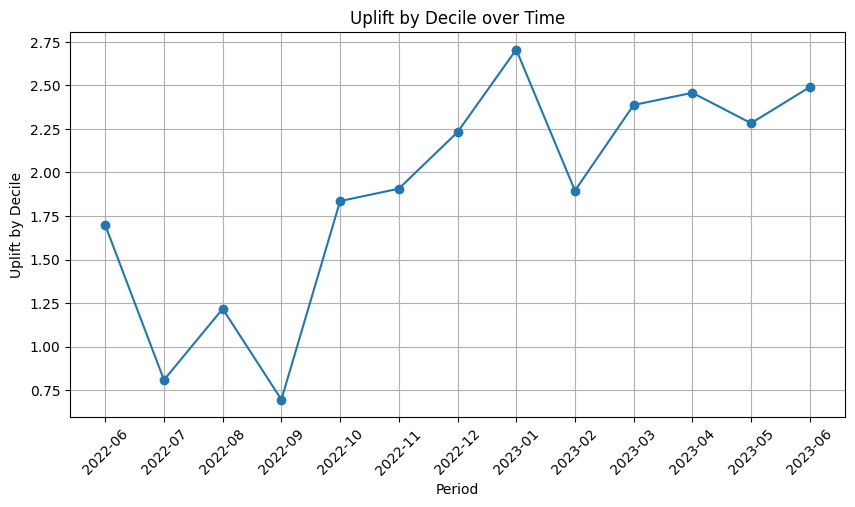

In [33]:
# Plot precision_decile values
plt.figure(figsize=(10, 5))
plt.plot(periods, precision_first_decile_values, marker='o')
plt.title('Precision Decile over Time')
plt.xlabel('Period')
plt.ylabel('Precision Decile')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

# Plot uplift_by_decile values
plt.figure(figsize=(10, 5))
plt.plot(periods, uplift_first_decile_values, marker='o')
plt.title('Uplift by Decile over Time')
plt.xlabel('Period')
plt.ylabel('Uplift by Decile')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

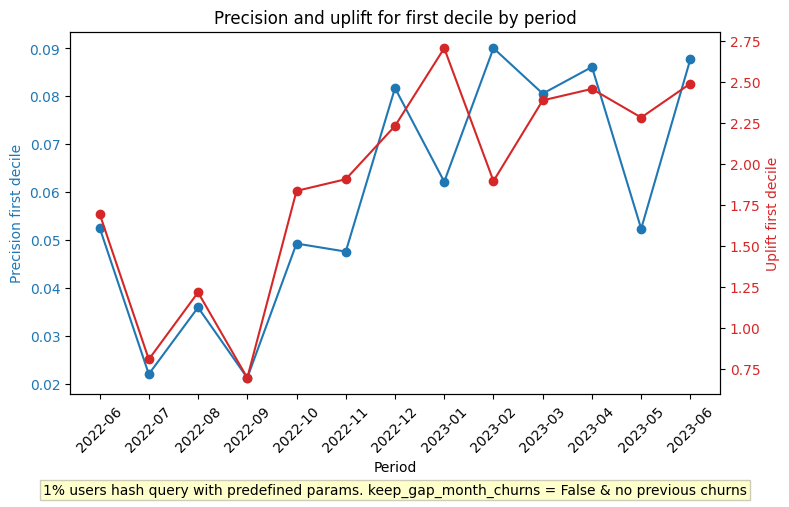

In [66]:
 # Create a figure and a set of subplots
fig, ax1 = plt.subplots(figsize=(8, 5))

# Plot precision_decile values
color = 'tab:blue'
ax1.set_xlabel('Period')
ax1.set_ylabel('Precision first decile', color=color)
ax1.plot(periods, precision_first_decile_values, color=color, marker='o')
ax1.tick_params(axis='y', labelcolor=color)

plt.xticks(rotation=45)

# Instantiate a second y-axis that shares the same x-axis
ax2 = ax1.twinx()

# Plot the first element of uplift_by_decile values
color = 'tab:red'
ax2.set_ylabel('Uplift first decile', color=color)
ax2.plot(periods, uplift_first_decile_values, color=color, marker='o')
ax2.tick_params(axis='y', labelcolor=color)

# Improve layout
plt.title('Precision and uplift for first decile by period')
fig.tight_layout()
plt.subplots_adjust(bottom=0.2)
plt.figtext(0.5, 0.001, "1% users hash query with predefined params. keep_gap_month_churns = False & no previous churns", ha="center", fontsize=10, bbox={"facecolor":"yellow", "alpha":0.2, "pad":2})
plt.show()

In [68]:
# FIX!
# avoid the warning for  PerformanceWarning: DataFrame is highly fragmented
import warnings
warnings.filterwarnings(action='ignore', category=pd.errors.PerformanceWarning)

# rever it back
#warnings.filterwarnings('default')


In [78]:
query = """
WITH selectable_customer_2022 AS (
    SELECT customer_id
    FROM `mm-bi-catedras-upm.ESTIMACION_CHURN.multibrand_monthly_customer_base_mp2022`
    GROUP BY customer_id
), 
customer_selected_2022 AS (
    SELECT customer_id AS selected_customer_2022
    FROM selectable_customer_2022
    WHERE MOD(ABS(FARM_FINGERPRINT(CAST(customer_id AS STRING))), 10) = 0
),
selectable_customer_2023 AS (
    SELECT customer_id
    FROM `mm-bi-catedras-upm.ESTIMACION_CHURN.multibrand_monthly_customer_base_mp2023_1`
    GROUP BY customer_id
), 
customer_selected_2023 AS (
    SELECT customer_id AS selected_customer_2023
    FROM selectable_customer_2023
    WHERE MOD(ABS(FARM_FINGERPRINT(CAST(customer_id AS STRING))), 10) = 0
),
churned_users AS (
    SELECT selected_customer_2022 AS customer_id
    FROM customer_selected_2022
    WHERE selected_customer_2022 NOT IN (SELECT selected_customer_2023 FROM customer_selected_2023)
),
combined_data AS (
    SELECT 
        2022 AS YEAR,
        cs2022.selected_customer_2022 AS customer_id,
        base2022.*,
        CASE 
            WHEN cs2022.selected_customer_2022 IN (SELECT customer_id FROM churned_users) 
            THEN TRUE 
            ELSE FALSE 
        END AS is_churned
    FROM customer_selected_2022 cs2022
    JOIN `mm-bi-catedras-upm.ESTIMACION_CHURN.multibrand_monthly_customer_base_mp2022` base2022
    ON cs2022.selected_customer_2022 = base2022.customer_id

    UNION ALL

    SELECT 
        2023 AS YEAR,
        cs2023.selected_customer_2023 AS customer_id,
        base2023.*,
        FALSE AS is_churned
    FROM customer_selected_2023 cs2023
    JOIN `mm-bi-catedras-upm.ESTIMACION_CHURN.multibrand_monthly_customer_base_mp2023_1` base2023
    ON cs2023.selected_customer_2023 = base2023.customer_id
)

SELECT *
FROM combined_data
WHERE IS_CUST_SEGM_RESI > 0
AND IS_CUST_BILL_POST_CURR = TRUE
AND CUST_BUNDLE_CURR = 'FMC'
AND NUM_IMPAGOS = 0
AND pago_final_0 IS NOT NULL
"""

In [80]:
get_initial_params()
raw_data = data_gathering(query, logger)
clean_data = data_cleaning(raw_data, logger)

INFO - Started querying data
INFO - Data succesfully retrieved! Length: 509539
INFO - Starting cleaning data
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Dropping column Import_Rest_quota_disp
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Dropping column NUM_FIX_PORT
INFO - Dropping column NUM_FIX_PORT_LAST_1_MONTH
INFO - Dropping column NUM_FIX_PORT_LAST_3_MONTHS
INFO - Dropping column NUM_FIX_PORT_LAST_6_MONTHS
INFO - Sh

INFO - Started querying data
INFO - Data succesfully retrieved! Length: 509539
INFO - Starting cleaning data
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Dropping column Import_Rest_quota_disp
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Dropping column NUM_FIX_PORT
INFO - Dropping column NUM_FIX_PORT_LAST_1_MONTH
INFO - Dropping column NUM_FIX_PORT_LAST_3_MONTHS
INFO - Dropping column NUM_FIX_PORT_LAST_6_MONTHS
INFO - Sh

[LightGBM] [Info] Number of positive: 375, number of negative: 13838
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.059261 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 66288
[LightGBM] [Info] Number of data points in the train set: 14213, number of used features: 346
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.026384 -> initscore=-3.608248
[LightGBM] [Info] Start training from score -3.608248


INFO - Completed model training!
INFO - Started evaluation for Pipeline(steps=[('lightgbm',
                 LGBMClassifier(colsample_bytree=0.64, learning_rate=0.005,
                                num_leaves=12, random_state=500, reg_alpha=0,
                                reg_lambda=1, subsample=0.7))])
INFO - Generating plots


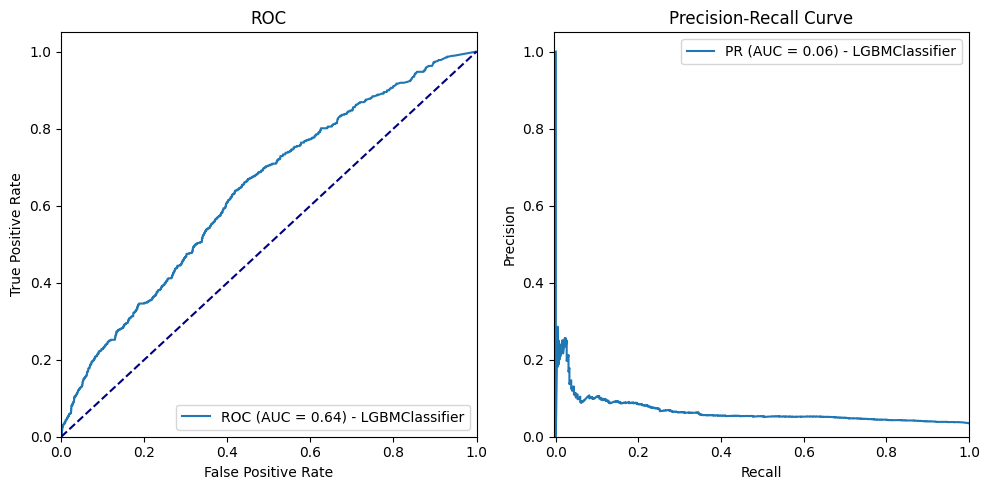

INFO - Precision in the first decile: 0.08
/home/dan1dr/zrive-ds-4q24-churn/src/evaluation.py:105: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
INFO - Uplift by decile:
INFO - decile
0    2.231947
1    1.225383
2    1.137856
3    1.334792
4    1.072210
5    0.706732
6    0.737188
7    0.617912
8    0.659494
9    0.280798
Name: y_true, dtype: float64
INFO - Completed evaluation!
INFO - Feature importance
INFO -                                 Feature  Coefficient
112                       NUM_PERM_CURR           66
115                        NUM_PREV_OBJ           56
0                          pago_final_0           55
43                   MAX_DAYS_PERM_CURR           48
164  service_fix_pending_install_3month           47
45              MIN_PENALTY_AMOUNT_CURR           29
168  service_fix_pending

[LightGBM] [Info] Number of positive: 457, number of negative: 12563
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.051511 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 66100
[LightGBM] [Info] Number of data points in the train set: 13020, number of used features: 345
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.035100 -> initscore=-3.313828
[LightGBM] [Info] Start training from score -3.313828


INFO - Completed model training!
INFO - Started evaluation for Pipeline(steps=[('lightgbm',
                 LGBMClassifier(colsample_bytree=0.64, learning_rate=0.005,
                                num_leaves=12, random_state=500, reg_alpha=0,
                                reg_lambda=1, subsample=0.7))])
INFO - Generating plots


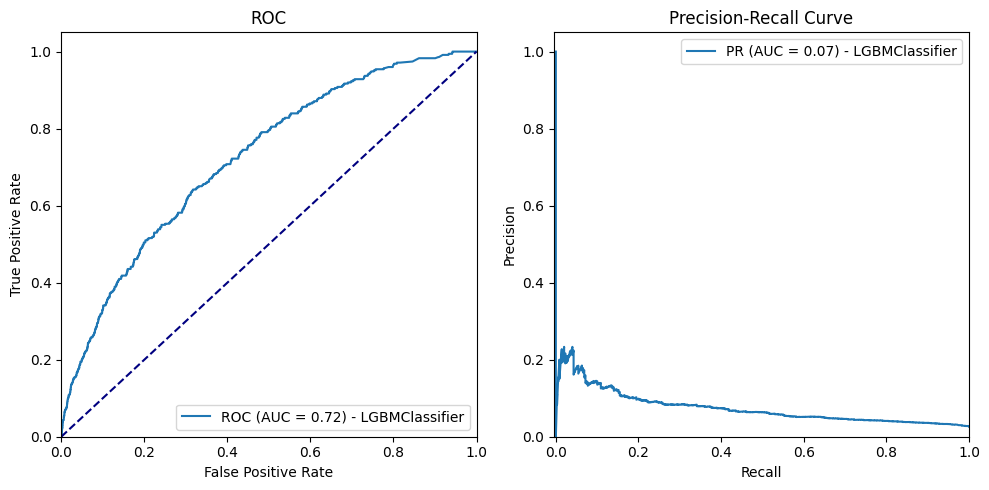

INFO - Precision in the first decile: 0.08
/home/dan1dr/zrive-ds-4q24-churn/src/evaluation.py:105: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
INFO - Uplift by decile:
INFO - decile
0    3.180516
1    1.719198
2    1.002865
3    1.146132
4    0.859599
5    0.716332
6    0.573497
7    0.413575
8    0.222376
9    0.171920
Name: y_true, dtype: float64
INFO - Completed evaluation!
INFO - Feature importance
INFO -                                  Feature  Coefficient
112                        NUM_PERM_CURR           68
150             dif_periodica_prev_month           42
173            pago_final_0_avg_6_months           36
130        cust_days_since_last_fix_port           36
171              pago_final_0_prev_month           35
0                           pago_final_0           33
76               

[LightGBM] [Info] Number of positive: 349, number of negative: 12961
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.054202 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 66062
[LightGBM] [Info] Number of data points in the train set: 13310, number of used features: 344
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.026221 -> initscore=-3.614628
[LightGBM] [Info] Start training from score -3.614628


INFO - Completed model training!
INFO - Started evaluation for Pipeline(steps=[('lightgbm',
                 LGBMClassifier(colsample_bytree=0.64, learning_rate=0.005,
                                num_leaves=12, random_state=500, reg_alpha=0,
                                reg_lambda=1, subsample=0.7))])
INFO - Generating plots


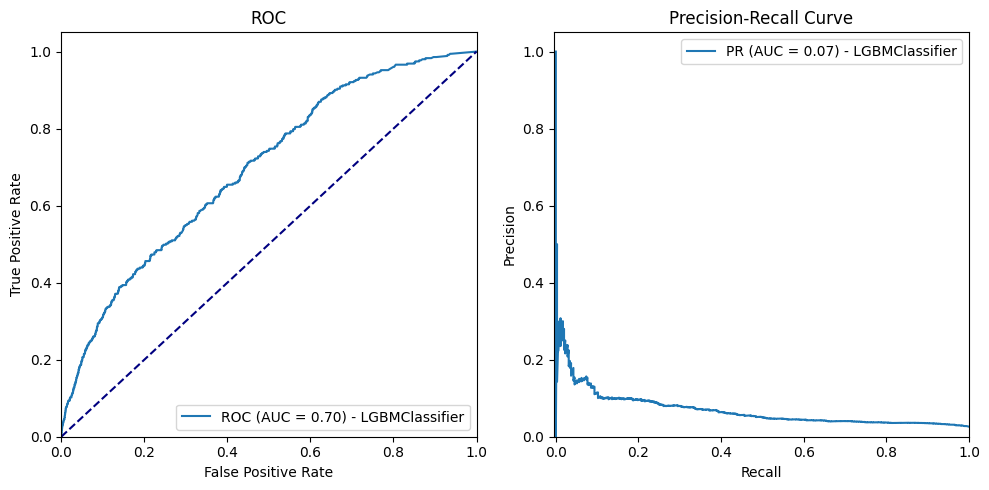

INFO - Precision in the first decile: 0.08
/home/dan1dr/zrive-ds-4q24-churn/src/evaluation.py:105: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
INFO - Uplift by decile:
INFO - decile
0    3.031385
1    1.359874
2    0.991575
3    1.104897
4    0.906583
5    0.906583
6    0.878252
7    0.386571
8    0.300754
9    0.139999
Name: y_true, dtype: float64
INFO - Completed evaluation!
INFO - Feature importance
INFO -                          Feature  Coefficient
112                NUM_PERM_CURR          140
160  service_fix_pending_install           62
151   dif_periodica_prev_2_month           44
76                 NUM_DISC_CURR           29
0                   pago_final_0           28
194      discount_0_std_3_months           27
189     periodica_0_std_3_months           26
150     dif_periodica_prev_

[LightGBM] [Info] Number of positive: 353, number of negative: 13188
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030521 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 66155
[LightGBM] [Info] Number of data points in the train set: 13541, number of used features: 345
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.026069 -> initscore=-3.620595
[LightGBM] [Info] Start training from score -3.620595


INFO - Completed model training!
INFO - Started evaluation for Pipeline(steps=[('lightgbm',
                 LGBMClassifier(colsample_bytree=0.64, learning_rate=0.005,
                                num_leaves=12, random_state=500, reg_alpha=0,
                                reg_lambda=1, subsample=0.7))])
INFO - Generating plots


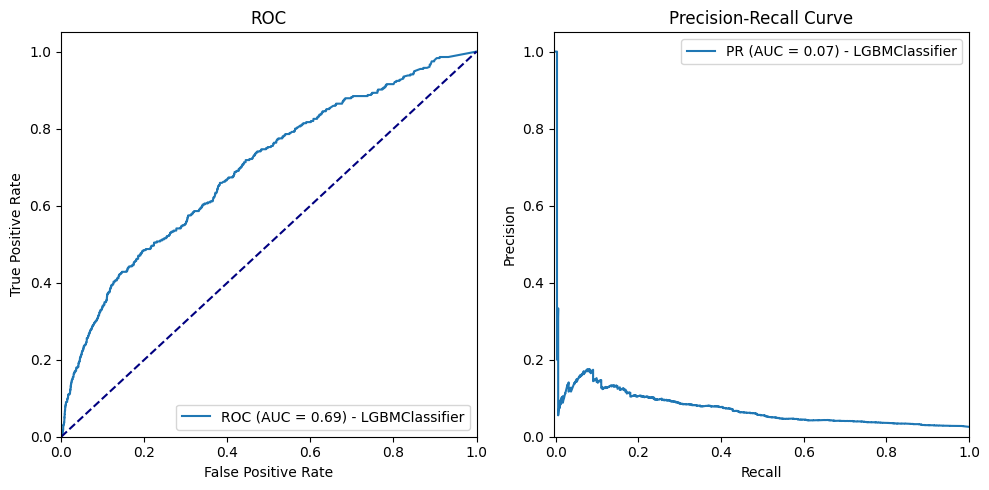

INFO - Precision in the first decile: 0.08
/home/dan1dr/zrive-ds-4q24-churn/src/evaluation.py:105: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
INFO - Uplift by decile:
INFO - decile
0    3.266425
1    1.493497
2    0.732130
3    1.127984
4    0.873555
5    0.675324
6    0.632286
7    0.359315
8    0.591336
9    0.253430
Name: y_true, dtype: float64
INFO - Completed evaluation!
INFO - Feature importance
INFO -                                 Feature  Coefficient
43                   MAX_DAYS_PERM_CURR           75
112                       NUM_PERM_CURR           67
38                   MIN_DAYS_PERM_CURR           58
3                           periodica_0           50
115                        NUM_PREV_OBJ           38
168  service_fix_pending_install_6month           38
152          dif_periodi

[LightGBM] [Info] Number of positive: 355, number of negative: 13480
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.038728 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 66272
[LightGBM] [Info] Number of data points in the train set: 13835, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.025660 -> initscore=-3.636845
[LightGBM] [Info] Start training from score -3.636845


INFO - Completed model training!
INFO - Started evaluation for Pipeline(steps=[('lightgbm',
                 LGBMClassifier(colsample_bytree=0.64, learning_rate=0.005,
                                num_leaves=12, random_state=500, reg_alpha=0,
                                reg_lambda=1, subsample=0.7))])
INFO - Generating plots


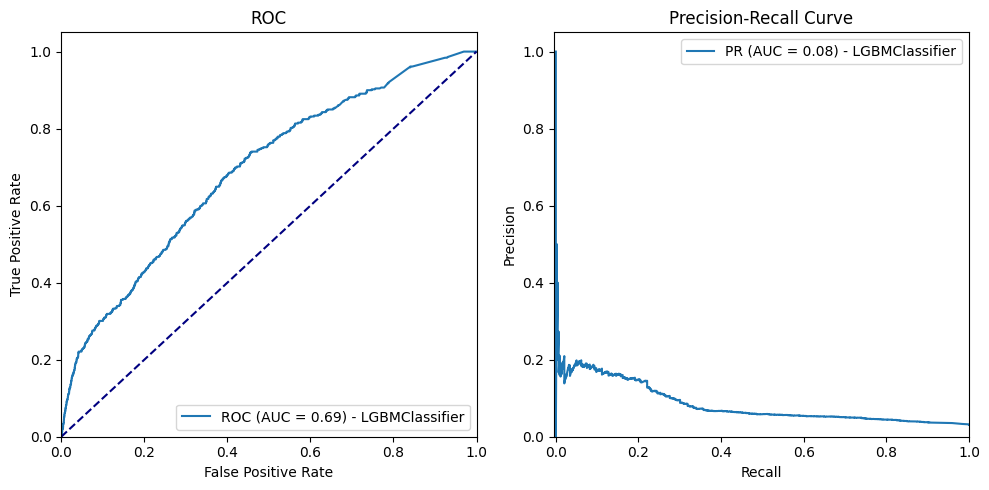

INFO - Precision in the first decile: 0.09
/home/dan1dr/zrive-ds-4q24-churn/src/evaluation.py:105: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
INFO - Uplift by decile:
INFO - decile
0    3.006194
1    1.184258
2    1.276261
3    1.252581
4    0.797663
5    0.729292
6    0.569759
7    0.417376
8    0.722902
9    0.257074
Name: y_true, dtype: float64
INFO - Completed evaluation!
INFO - Feature importance
INFO -                               Feature  Coefficient
43                 MAX_DAYS_PERM_CURR           76
112                     NUM_PERM_CURR           63
38                 MIN_DAYS_PERM_CURR           50
0                        pago_final_0           30
189          periodica_0_std_3_months           29
150          dif_periodica_prev_month           25
40   NUM_DAYS_LINE_TYPE_MAIN_POST_ACT 

[LightGBM] [Info] Number of positive: 439, number of negative: 13648
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033187 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 66154
[LightGBM] [Info] Number of data points in the train set: 14087, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.031163 -> initscore=-3.436849
[LightGBM] [Info] Start training from score -3.436849


INFO - Completed model training!
INFO - Started evaluation for Pipeline(steps=[('lightgbm',
                 LGBMClassifier(colsample_bytree=0.64, learning_rate=0.005,
                                num_leaves=12, random_state=500, reg_alpha=0,
                                reg_lambda=1, subsample=0.7))])
INFO - Generating plots


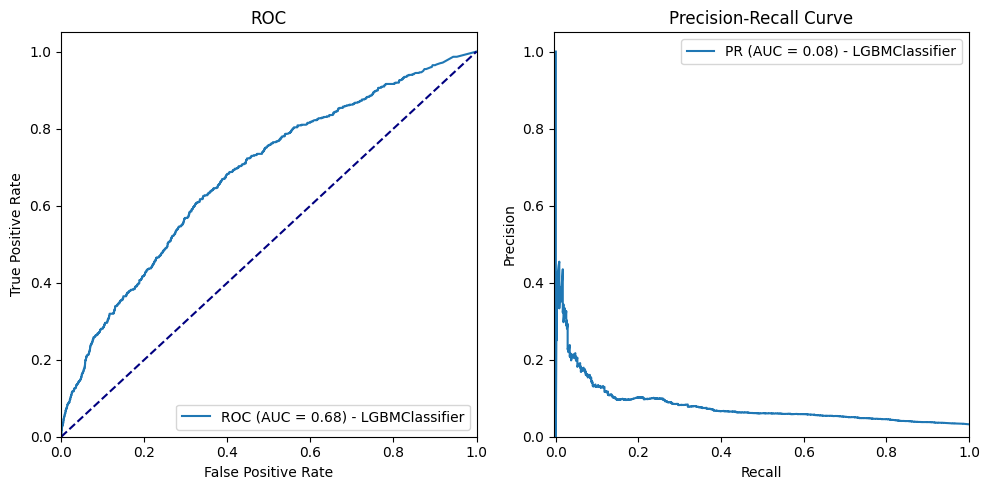

INFO - Precision in the first decile: 0.09
/home/dan1dr/zrive-ds-4q24-churn/src/evaluation.py:105: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
INFO - Uplift by decile:
INFO - decile
0    2.771908
1    1.327875
2    1.411918
3    1.176598
4    0.807247
5    0.638379
6    0.487712
7    0.537582
8    0.499350
9    0.344580
Name: y_true, dtype: float64
INFO - Completed evaluation!
INFO - Feature importance
INFO -                            Feature  Coefficient
112                  NUM_PERM_CURR           66
152     dif_periodica_prev_3_month           65
43              MAX_DAYS_PERM_CURR           61
143    dif_pago_final_prev_3_month           42
150       dif_periodica_prev_month           41
186         periodica_0_prev_month           30
131  cust_days_since_last_mob_port           29
106        

[LightGBM] [Info] Number of positive: 595, number of negative: 17867
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.068183 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 66605
[LightGBM] [Info] Number of data points in the train set: 18462, number of used features: 344
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.032228 -> initscore=-3.402149
[LightGBM] [Info] Start training from score -3.402149


INFO - Completed model training!
INFO - Started evaluation for Pipeline(steps=[('lightgbm',
                 LGBMClassifier(colsample_bytree=0.64, learning_rate=0.005,
                                num_leaves=12, random_state=500, reg_alpha=0,
                                reg_lambda=1, subsample=0.7))])
INFO - Generating plots


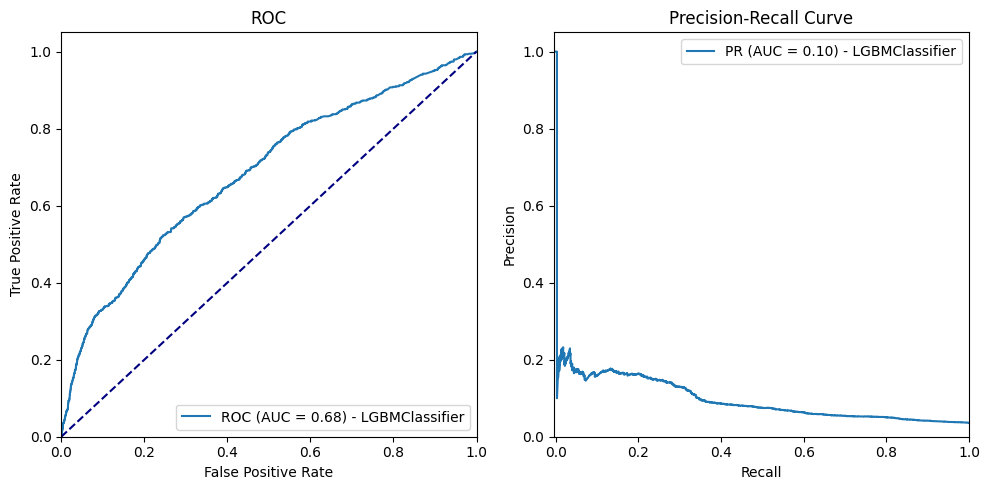

INFO - Precision in the first decile: 0.12
/home/dan1dr/zrive-ds-4q24-churn/src/evaluation.py:105: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
INFO - Uplift by decile:
INFO - decile
0    3.251043
1    1.188407
2    1.174747
3    0.834078
4    0.819591
5    0.887450
6    0.423665
7    0.494454
8    0.437985
9    0.488121
Name: y_true, dtype: float64
INFO - Completed evaluation!
INFO - Feature importance
INFO -                            Feature  Coefficient
112                  NUM_PERM_CURR           72
38              MIN_DAYS_PERM_CURR           61
150       dif_periodica_prev_month           51
76                   NUM_DISC_CURR           40
189       periodica_0_std_3_months           39
131  cust_days_since_last_mob_port           36
188       periodica_0_avg_6_months           27
115        

[LightGBM] [Info] Number of positive: 732, number of negative: 19416
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.077216 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 66651
[LightGBM] [Info] Number of data points in the train set: 20148, number of used features: 345
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036331 -> initscore=-3.278072
[LightGBM] [Info] Start training from score -3.278072


INFO - Completed model training!
INFO - Started evaluation for Pipeline(steps=[('lightgbm',
                 LGBMClassifier(colsample_bytree=0.64, learning_rate=0.005,
                                num_leaves=12, random_state=500, reg_alpha=0,
                                reg_lambda=1, subsample=0.7))])
INFO - Generating plots


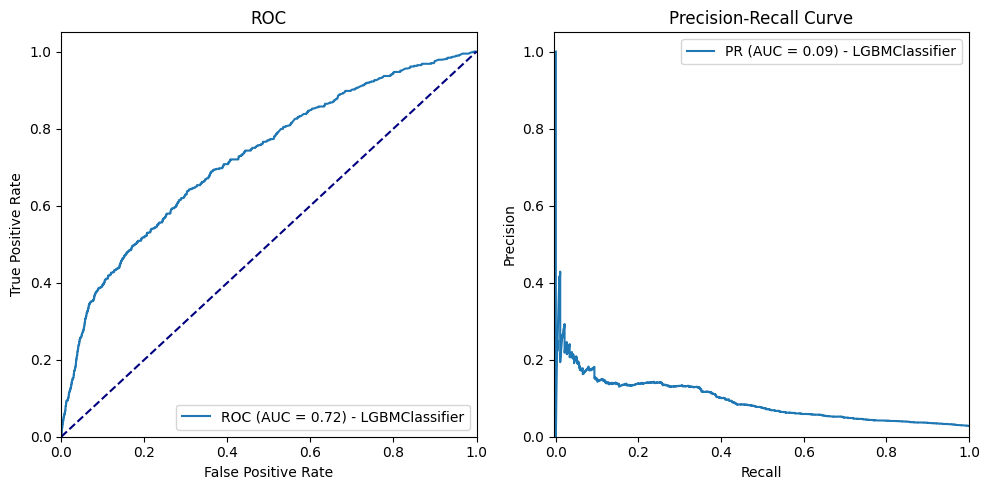

INFO - Precision in the first decile: 0.11
/home/dan1dr/zrive-ds-4q24-churn/src/evaluation.py:105: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
INFO - Uplift by decile:
INFO - decile
0    3.855825
1    1.232455
2    1.109210
3    0.880325
4    0.581015
5    0.774686
6    0.546614
7    0.439510
8    0.283247
9    0.297542
Name: y_true, dtype: float64
INFO - Completed evaluation!
INFO - Feature importance
INFO -                                 Feature  Coefficient
183           aperiodica_0_avg_6_months           67
112                       NUM_PERM_CURR           67
74     NUM_DAYS_LINE_TYPE_FIXE_POST_ACT           60
43                   MAX_DAYS_PERM_CURR           48
211           NUM_GB_3G_CURR_prev_month           48
164  service_fix_pending_install_3month           42
160         service_fix_

[LightGBM] [Info] Number of positive: 568, number of negative: 19623
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.043297 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 66643
[LightGBM] [Info] Number of data points in the train set: 20191, number of used features: 345
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.028131 -> initscore=-3.542336
[LightGBM] [Info] Start training from score -3.542336


INFO - Completed model training!
INFO - Started evaluation for Pipeline(steps=[('lightgbm',
                 LGBMClassifier(colsample_bytree=0.64, learning_rate=0.005,
                                num_leaves=12, random_state=500, reg_alpha=0,
                                reg_lambda=1, subsample=0.7))])
INFO - Generating plots


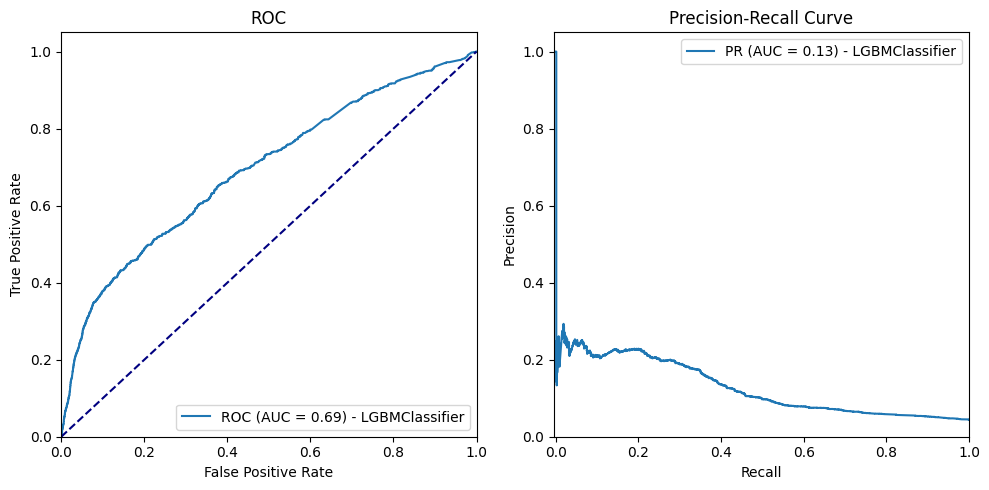

INFO - Precision in the first decile: 0.16
/home/dan1dr/zrive-ds-4q24-churn/src/evaluation.py:105: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
INFO - Uplift by decile:
INFO - decile
0    3.574654
1    1.111439
2    0.835919
3    1.067422
4    0.682942
5    0.648299
6    0.619355
7    0.623609
8    0.395184
9    0.439525
Name: y_true, dtype: float64
INFO - Completed evaluation!
INFO - Feature importance
INFO -                               Feature  Coefficient
112                     NUM_PERM_CURR          104
43                 MAX_DAYS_PERM_CURR           65
74   NUM_DAYS_LINE_TYPE_FIXE_POST_ACT           42
187          periodica_0_avg_3_months           39
182         aperiodica_0_avg_3_months           36
115                      NUM_PREV_OBJ           32
76                      NUM_DISC_CURR 

[LightGBM] [Info] Number of positive: 909, number of negative: 19417
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.082828 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 66700
[LightGBM] [Info] Number of data points in the train set: 20326, number of used features: 345
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.044721 -> initscore=-3.061559
[LightGBM] [Info] Start training from score -3.061559


INFO - Completed model training!
INFO - Started evaluation for Pipeline(steps=[('lightgbm',
                 LGBMClassifier(colsample_bytree=0.64, learning_rate=0.005,
                                num_leaves=12, random_state=500, reg_alpha=0,
                                reg_lambda=1, subsample=0.7))])
INFO - Generating plots


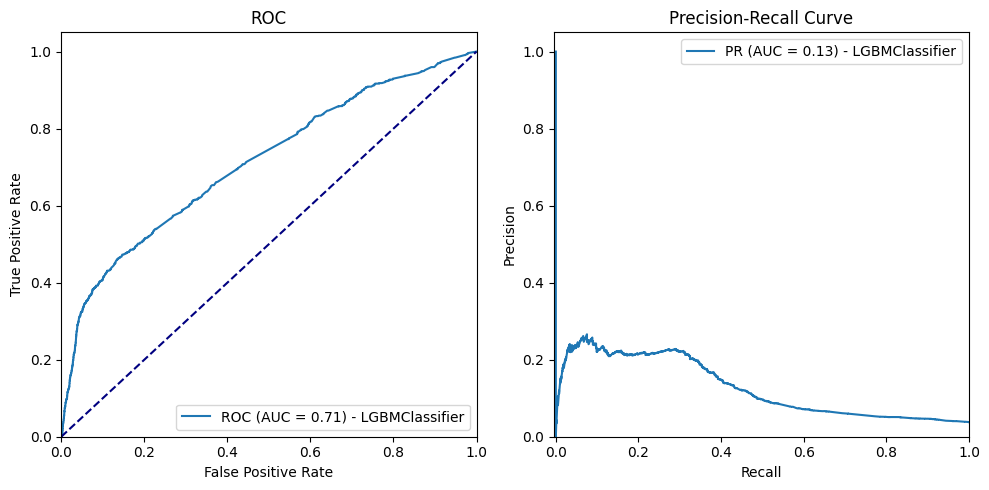

INFO - Precision in the first decile: 0.15
/home/dan1dr/zrive-ds-4q24-churn/src/evaluation.py:105: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
INFO - Uplift by decile:
INFO - decile
0    3.936230
1    1.078241
2    0.822074
3    0.892874
4    0.758468
5    0.635920
6    0.679548
7    0.542937
8    0.324451
9    0.402121
Name: y_true, dtype: float64
INFO - Completed evaluation!
INFO - Feature importance
INFO -                                 Feature  Coefficient
112                       NUM_PERM_CURR          118
164  service_fix_pending_install_3month           56
183           aperiodica_0_avg_6_months           44
43                   MAX_DAYS_PERM_CURR           40
131       cust_days_since_last_mob_port           35
38                   MIN_DAYS_PERM_CURR           35
74     NUM_DAYS_LINE_TYP

[LightGBM] [Info] Number of positive: 770, number of negative: 19506
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.080966 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 66693
[LightGBM] [Info] Number of data points in the train set: 20276, number of used features: 344
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.037976 -> initscore=-3.232087
[LightGBM] [Info] Start training from score -3.232087


INFO - Completed model training!
INFO - Started evaluation for Pipeline(steps=[('lightgbm',
                 LGBMClassifier(colsample_bytree=0.64, learning_rate=0.005,
                                num_leaves=12, random_state=500, reg_alpha=0,
                                reg_lambda=1, subsample=0.7))])
INFO - Generating plots


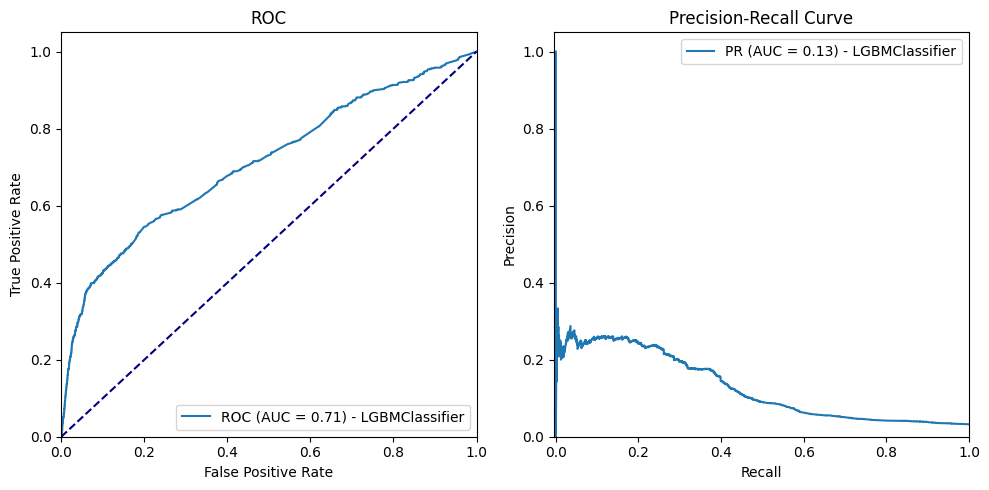

INFO - Precision in the first decile: 0.13
/home/dan1dr/zrive-ds-4q24-churn/src/evaluation.py:105: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
INFO - Uplift by decile:
INFO - decile
0    4.156198
1    1.150232
2    0.614537
3    0.780188
4    0.558069
5    0.585448
6    0.789264
7    0.482581
8    0.434613
9    0.428762
Name: y_true, dtype: float64
INFO - Completed evaluation!
INFO - Feature importance
INFO -                                 Feature  Coefficient
38                   MIN_DAYS_PERM_CURR           81
112                       NUM_PERM_CURR           74
168  service_fix_pending_install_6month           43
150            dif_periodica_prev_month           43
164  service_fix_pending_install_3month           38
151          dif_periodica_prev_2_month           35
182           aperiodica

[LightGBM] [Info] Number of positive: 647, number of negative: 19376
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.088693 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 66687
[LightGBM] [Info] Number of data points in the train set: 20023, number of used features: 346
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.032313 -> initscore=-3.399444
[LightGBM] [Info] Start training from score -3.399444


INFO - Completed model training!
INFO - Started evaluation for Pipeline(steps=[('lightgbm',
                 LGBMClassifier(colsample_bytree=0.64, learning_rate=0.005,
                                num_leaves=12, random_state=500, reg_alpha=0,
                                reg_lambda=1, subsample=0.7))])
INFO - Generating plots


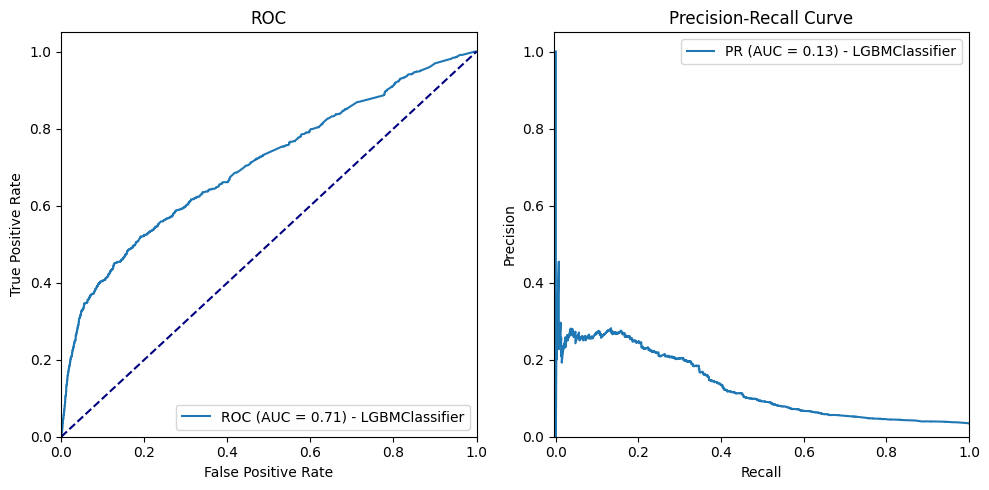

INFO - Precision in the first decile: 0.14
/home/dan1dr/zrive-ds-4q24-churn/src/evaluation.py:105: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
INFO - Uplift by decile:
INFO - decile
0    3.965319
1    1.152433
2    0.815009
3    0.689621
4    0.743450
5    0.563109
6    0.653106
7    0.542621
8    0.560686
9    0.364166
Name: y_true, dtype: float64
INFO - Completed evaluation!
INFO - Feature importance
INFO -                                 Feature  Coefficient
112                       NUM_PERM_CURR           63
38                   MIN_DAYS_PERM_CURR           62
152          dif_periodica_prev_3_month           58
164  service_fix_pending_install_3month           54
168  service_fix_pending_install_6month           44
154         dif_aperiodica_prev_2_month           30
105                     

[LightGBM] [Info] Number of positive: 696, number of negative: 19273
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.133747 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 66648
[LightGBM] [Info] Number of data points in the train set: 19969, number of used features: 343
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.034854 -> initscore=-3.321111
[LightGBM] [Info] Start training from score -3.321111


INFO - Completed model training!
INFO - Started evaluation for Pipeline(steps=[('lightgbm',
                 LGBMClassifier(colsample_bytree=0.64, learning_rate=0.005,
                                num_leaves=12, random_state=500, reg_alpha=0,
                                reg_lambda=1, subsample=0.7))])
INFO - Generating plots


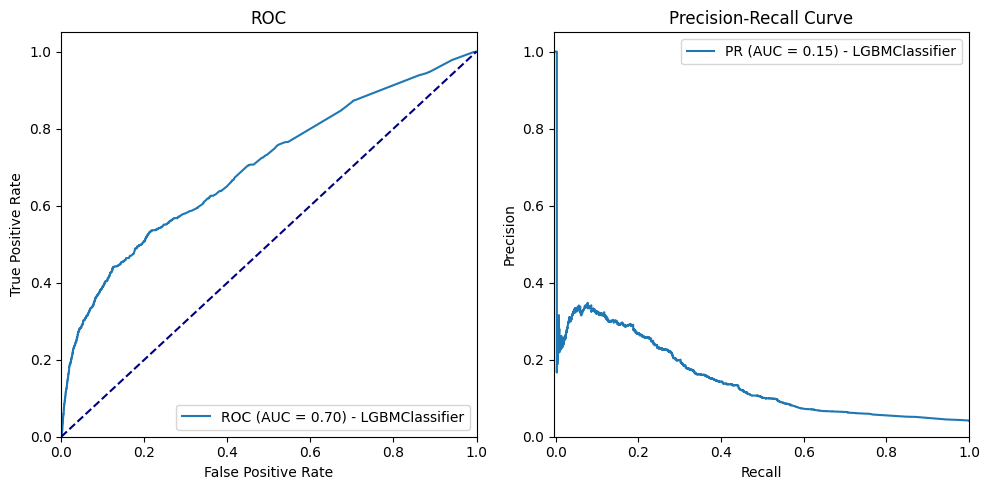

INFO - Precision in the first decile: 0.16
/home/dan1dr/zrive-ds-4q24-churn/src/evaluation.py:105: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
INFO - Uplift by decile:
INFO - decile
0    3.706230
1    1.256801
2    0.780691
3    0.670080
4    0.866585
5    0.674670
6    0.656280
7    0.676082
8    0.416807
9    0.478019
Name: y_true, dtype: float64
INFO - Completed evaluation!
INFO - Feature importance
INFO -                                 Feature  Coefficient
76                        NUM_DISC_CURR           70
43                   MAX_DAYS_PERM_CURR           66
164  service_fix_pending_install_3month           60
182           aperiodica_0_avg_3_months           52
131       cust_days_since_last_mob_port           52
188            periodica_0_avg_6_months           30
141           dif_pago_f

In [70]:
get_initial_params()
raw_data = data_gathering(query, logger)
clean_data = data_cleaning(raw_data, logger)

all_datav2 = {}
last_train_period = pd.to_datetime(end_date) - pd.DateOffset(months=3)
train_from = pd.to_datetime(train_from)
train_to = pd.to_datetime(train_to)


while train_to <= last_train_period:

    logger.info(f"MODEL FOR {train_to}")

    str_train_from = train_from.strftime('%Y-%m-%d')
    str_train_to = train_to.strftime('%Y-%m-%d')

    features, target, features_test, target_test = feature_computation(
        clean_data, str_train_from, str_train_to, logger
    )
    logger.info(f"{type(train_from)}")
    model = modeling(features, target, lightgbm_params, logger)
    model_metrics, precision_decile, uplift_by_decile, feature_importance = evaluation(
    model, features_test, target_test, logger, save_curves_path)

    all_datav2[train_to.strftime('%Y-%m')] = {
        'features': features,
        'target': target,
        'features_test': features_test,
        'target_test': target_test,
        'model': model,
        'metrics': model_metrics,
        'precision_decile': precision_decile,
        'uplift_by_decile': uplift_by_decile,
        'feature_importance': feature_importance
    }
    #to-do pass directly datetimes into feature_computation and not use this here 

    train_from += pd.DateOffset(months=1)
    train_to += pd.DateOffset(months=1)


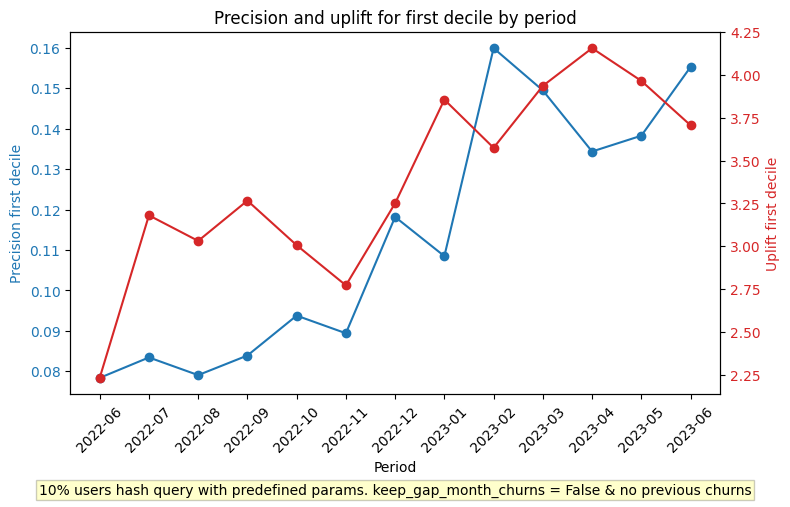

In [71]:
precision_first_decile_values = []
uplift_first_decile_values = []

for period in all_datav2:
    precision_first_decile_values.append(all_datav2[period]['precision_decile'])
    uplift_first_decile_values.append(all_datav2[period]['uplift_by_decile'][0])

periods = list(all_data.keys())

 # Create a figure and a set of subplots
fig, ax1 = plt.subplots(figsize=(8, 5))

# Plot precision_decile values
color = 'tab:blue'
ax1.set_xlabel('Period')
ax1.set_ylabel('Precision first decile', color=color)
ax1.plot(periods, precision_first_decile_values, color=color, marker='o')
ax1.tick_params(axis='y', labelcolor=color)

plt.xticks(rotation=45)

# Instantiate a second y-axis that shares the same x-axis
ax2 = ax1.twinx()

# Plot the first element of uplift_by_decile values
color = 'tab:red'
ax2.set_ylabel('Uplift first decile', color=color)
ax2.plot(periods, uplift_first_decile_values, color=color, marker='o')
ax2.tick_params(axis='y', labelcolor=color)

# Improve layout
plt.title('Precision and uplift for first decile by period')
fig.tight_layout()
plt.subplots_adjust(bottom=0.2)
plt.figtext(0.5, 0.001, "10% users hash query with predefined params. keep_gap_month_churns = False & no previous churns", ha="center", fontsize=10, bbox={"facecolor":"yellow", "alpha":0.2, "pad":2})
plt.show()

In [88]:
query = """
WITH all_periods AS (
  SELECT * 
  FROM `mm-bi-catedras-upm.ESTIMACION_CHURN.multibrand_monthly_customer_base_mp2022`
  UNION ALL 
  SELECT * 
  FROM `mm-bi-catedras-upm.ESTIMACION_CHURN.multibrand_monthly_customer_base_mp2023_1`
), 

selectable_customer AS (
    SELECT customer_id
    FROM all_periods
    GROUP BY customer_id
), 

customer_selected AS (
    SELECT customer_id AS selected_customer
    FROM selectable_customer
    WHERE RAND() < 0.2
)

SELECT *
FROM all_periods
INNER JOIN customer_selected
ON customer_id = selected_customer
WHERE IS_CUST_SEGM_RESI > 0
AND IS_CUST_BILL_POST_CURR = TRUE
AND CUST_BUNDLE_CURR = 'FMC'
AND NUM_IMPAGOS = 0
AND pago_final_0 IS NOT NULL
"""

with 20%

INFO - Started querying data
INFO - Data succesfully retrieved! Length: 1019755
INFO - Starting cleaning data
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Dropping column Import_Rest_quota_disp
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Dropping column NUM_FIX_PORT
INFO - Dropping column NUM_FIX_PORT_LAST_1_MONTH
INFO - Dropping column NUM_FIX_PORT_LAST_3_MONTHS
INFO - Dropping column NUM_FIX_PORT_LAST_6_MONTHS
INFO - S

[LightGBM] [Info] Number of positive: 1349, number of negative: 38651
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.270883 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 67422
[LightGBM] [Info] Number of data points in the train set: 40000, number of used features: 348
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.033725 -> initscore=-3.355209
[LightGBM] [Info] Start training from score -3.355209


INFO - Completed model training!
INFO - Started evaluation for Pipeline(steps=[('lightgbm',
                 LGBMClassifier(colsample_bytree=0.64, learning_rate=0.005,
                                num_leaves=12, random_state=500, reg_alpha=0,
                                reg_lambda=1, subsample=0.7))])
INFO - Generating plots


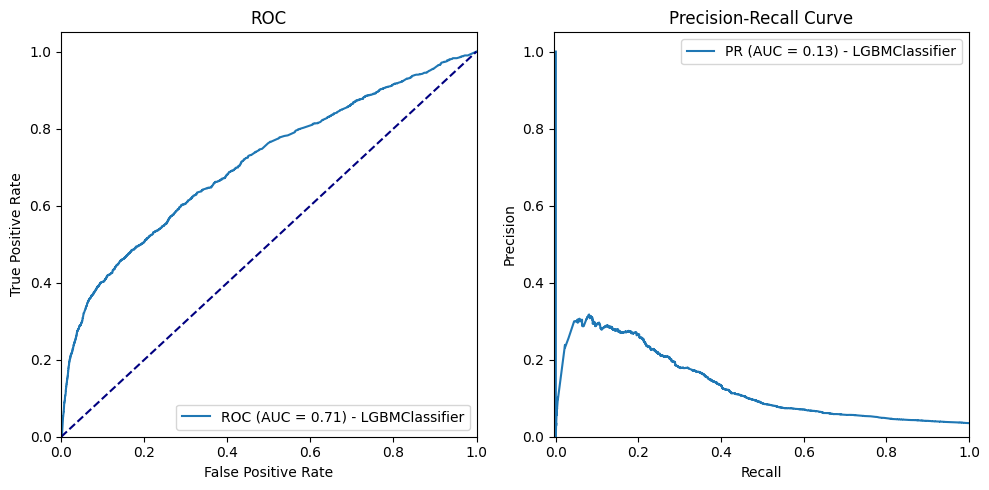

INFO - Precision in the first decile: 0.14
/home/dan1dr/zrive-ds-4q24-churn/src/evaluation.py:105: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
INFO - Uplift by decile:
INFO - decile
0    3.908603
1    1.069873
2    1.034211
3    0.698531
4    0.821580
5    0.560110
6    0.516882
7    0.522776
8    0.451963
9    0.437917
Name: y_true, dtype: float64
INFO - Completed evaluation!
INFO - Feature importance
INFO -                                 Feature  Coefficient
112                       NUM_PERM_CURR           93
164  service_fix_pending_install_3month           60
182           aperiodica_0_avg_3_months           53
43                   MAX_DAYS_PERM_CURR           52
150            dif_periodica_prev_month           49
76                        NUM_DISC_CURR           39
143         dif_pago_fin

In [89]:
get_initial_params()
raw_data = data_gathering(query, logger)
clean_data = data_cleaning(raw_data, logger)
features, target, features_test, target_test = feature_computation(
    clean_data,
    train_from,
    train_to,
    logger,
    save_features_path=save_features_path,
    save_target_path=save_target_path,
)
model = modeling(features, target, lightgbm_params, logger)
model_metrics, precision_decile, uplift_by_decile, feature_importance = evaluation(
    model, features_test, target_test, logger, save_curves_path
)

with 15% of users

INFO - Started querying data
INFO - Data succesfully retrieved! Length: 762831
INFO - Starting cleaning data
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Dropping column Import_Rest_quota_disp
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Dropping column NUM_FIX_PORT
INFO - Dropping column NUM_FIX_PORT_LAST_1_MONTH
INFO - Dropping column NUM_FIX_PORT_LAST_3_MONTHS
INFO - Dropping column NUM_FIX_PORT_LAST_6_MONTHS
INFO - Sh

[LightGBM] [Info] Number of positive: 992, number of negative: 29127
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.164262 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 67047
[LightGBM] [Info] Number of data points in the train set: 30119, number of used features: 347
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.032936 -> initscore=-3.379698
[LightGBM] [Info] Start training from score -3.379698


INFO - Completed model training!
INFO - Started evaluation for Pipeline(steps=[('lightgbm',
                 LGBMClassifier(colsample_bytree=0.64, learning_rate=0.005,
                                num_leaves=12, random_state=500, reg_alpha=0,
                                reg_lambda=1, subsample=0.7))])
INFO - Generating plots


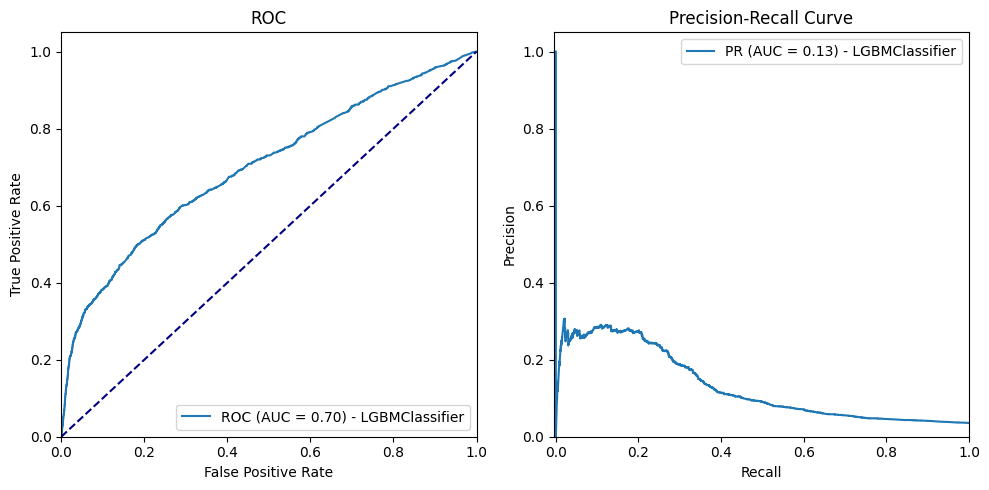

INFO - Precision in the first decile: 0.13
/home/dan1dr/zrive-ds-4q24-churn/src/evaluation.py:105: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
INFO - Uplift by decile:
INFO - decile
0    3.711708
1    1.300239
2    0.976617
3    0.595507
4    0.702505
5    0.618205
6    0.591488
7    0.630851
8    0.452768
9    0.435436
Name: y_true, dtype: float64
INFO - Completed evaluation!
INFO - Feature importance
INFO -                                 Feature  Coefficient
112                       NUM_PERM_CURR           73
151          dif_periodica_prev_2_month           73
164  service_fix_pending_install_3month           61
38                   MIN_DAYS_PERM_CURR           54
43                   MAX_DAYS_PERM_CURR           52
150            dif_periodica_prev_month           32
168  service_fix_pending

In [87]:
get_initial_params()
raw_data = data_gathering(query, logger)
clean_data = data_cleaning(raw_data, logger)
features, target, features_test, target_test = feature_computation(
    clean_data,
    train_from,
    train_to,
    logger,
    save_features_path=save_features_path,
    save_target_path=save_target_path,
)
model = modeling(features, target, lightgbm_params, logger)
model_metrics, precision_decile, uplift_by_decile, feature_importance = evaluation(
    model, features_test, target_test, logger, save_curves_path
)

with 10% users

INFO - Started querying data
INFO - Data succesfully retrieved! Length: 511592
INFO - Starting cleaning data
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Dropping column Import_Rest_quota_disp
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Dropping column NUM_FIX_PORT
INFO - Dropping column NUM_FIX_PORT_LAST_1_MONTH
INFO - Dropping column NUM_FIX_PORT_LAST_3_MONTHS
INFO - Dropping column NUM_FIX_PORT_LAST_6_MONTHS
INFO - Sh

[LightGBM] [Info] Number of positive: 719, number of negative: 19243
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.109387 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 66718
[LightGBM] [Info] Number of data points in the train set: 19962, number of used features: 344
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036018 -> initscore=-3.287041
[LightGBM] [Info] Start training from score -3.287041


INFO - Completed model training!
INFO - Started evaluation for Pipeline(steps=[('lightgbm',
                 LGBMClassifier(colsample_bytree=0.64, learning_rate=0.005,
                                num_leaves=12, random_state=500, reg_alpha=0,
                                reg_lambda=1, subsample=0.7))])
INFO - Generating plots


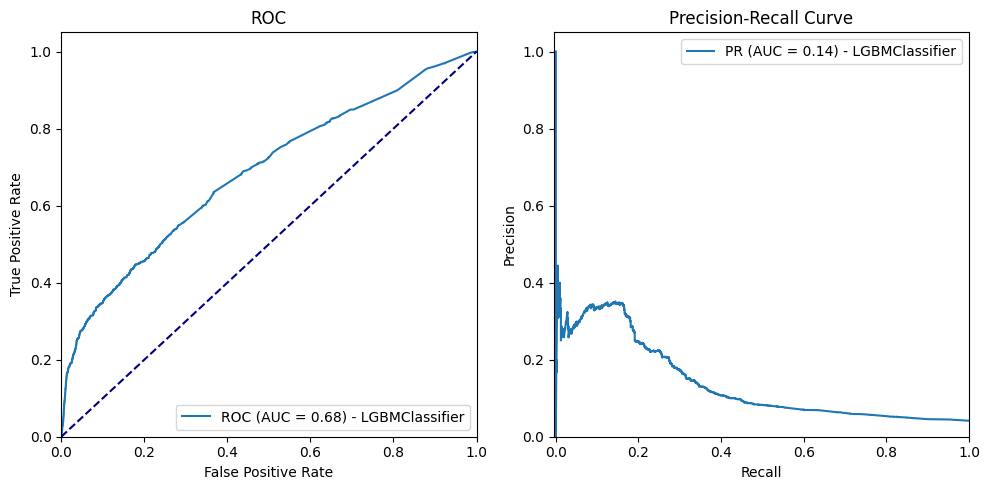

INFO - Precision in the first decile: 0.14
/home/dan1dr/zrive-ds-4q24-churn/src/evaluation.py:105: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
INFO - Uplift by decile:
INFO - decile
0    3.401319
1    1.113944
2    1.024298
3    1.034525
4    0.671849
5    0.838528
6    0.573094
7    0.223387
8    0.585663
9    0.391519
Name: y_true, dtype: float64
INFO - Completed evaluation!
INFO - Feature importance
INFO -                                 Feature  Coefficient
164  service_fix_pending_install_3month           57
141           dif_pago_final_prev_month           53
152          dif_periodica_prev_3_month           45
182           aperiodica_0_avg_3_months           39
38                   MIN_DAYS_PERM_CURR           38
150            dif_periodica_prev_month           36
143         dif_pago_fin

In [84]:
get_initial_params()
raw_data = data_gathering(query, logger)
clean_data = data_cleaning(raw_data, logger)
features, target, features_test, target_test = feature_computation(
    clean_data,
    train_from,
    train_to,
    logger,
    save_features_path=save_features_path,
    save_target_path=save_target_path,
)
model = modeling(features, target, lightgbm_params, logger)
model_metrics, precision_decile, uplift_by_decile, feature_importance = evaluation(
    model, features_test, target_test, logger, save_curves_path
)

INFO - Starting feature computation
INFO - Train computation from 2022-12-01 00:00:00 to 2023-05-01 00:00:00. Target for 2023-07-01 00:00:00
INFO - Test computation from 2023-01-01 00:00:00 to 2023-06-01 00:00:00. Target for 2023-08-01 00:00:00
INFO - Removing 4528 previous churned users from train set
INFO - Removing 4821 previous churned users from test set
INFO - Unique customers in train: 22200
INFO - Unique customers in test: 21983
INFO - Starting features and target computation
INFO - Initial number of features passed: 176
INFO - Starting computation
INFO - Final number of features computed: 354
INFO - Length train data: 20648
INFO - Length test data: 20450
INFO - Computation done!
INFO - Features: ['pago_final_0', 'consumo_0', 'aperiodica_0', 'periodica_0', 'discount_0', 'ajuste_0', 'NUM_GB_OWNN_CURR', 'NUM_GB_2G_CURR', 'NUM_GB_3G_CURR', 'NUM_GB_4G_CURR', 'NUM_GB_5G_CURR', 'NUM_SESS_CURR', 'NUM_SECS_CURR', 'PERC_SECS_TYPE_IN_CURR', 'PERC_SECS_TYPE_OUT_CURR', 'PERC_SECS_OWNN_CURR

[LightGBM] [Info] Number of positive: 616, number of negative: 19492
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.079878 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 66649
[LightGBM] [Info] Number of data points in the train set: 20108, number of used features: 345
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.030635 -> initscore=-3.454512
[LightGBM] [Info] Start training from score -3.454512


INFO - Completed model training!
INFO - Started evaluation for Pipeline(steps=[('lightgbm',
                 LGBMClassifier(colsample_bytree=0.64, learning_rate=0.005,
                                num_leaves=12, random_state=500, reg_alpha=0,
                                reg_lambda=1, subsample=0.7))])
INFO - Generating plots


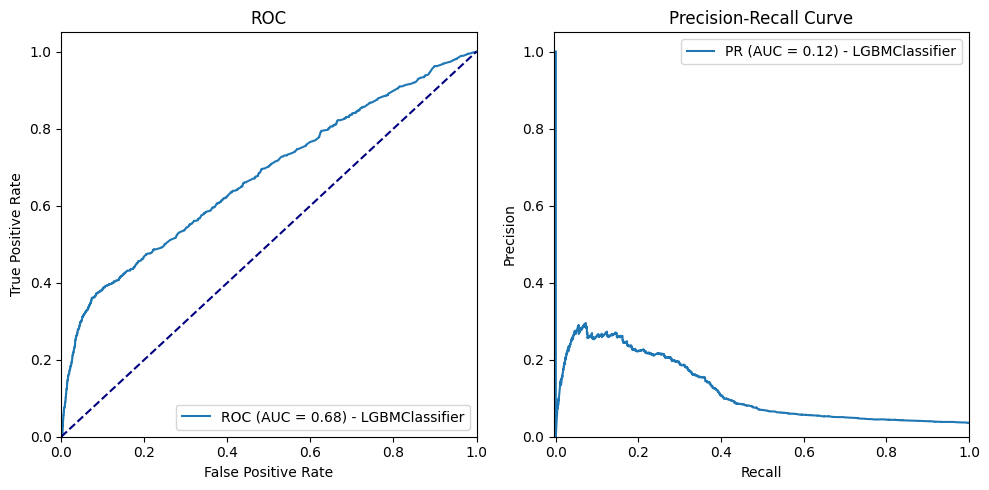

INFO - Precision in the first decile: 0.14
/home/dan1dr/zrive-ds-4q24-churn/src/evaluation.py:105: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
INFO - Uplift by decile:
INFO - decile
0    3.753711
1    0.826636
2    0.778967
3    0.826066
4    0.794439
5    0.623086
6    0.734133
7    0.616649
8    0.631302
9    0.410299
Name: y_true, dtype: float64
INFO - Completed evaluation!
INFO - Feature importance
INFO -                                 Feature  Coefficient
112                       NUM_PERM_CURR          134
164  service_fix_pending_install_3month           57
150            dif_periodica_prev_month           55
182           aperiodica_0_avg_3_months           49
186              periodica_0_prev_month           47
74     NUM_DAYS_LINE_TYPE_FIXE_POST_ACT           33
38                   MIN

In [85]:
get_initial_params()
features, target, features_test, target_test = feature_computation(
    clean_data,
    train_from,
    train_to,
    logger,
    save_features_path=save_features_path,
    save_target_path=save_target_path,
)
model = modeling(features, target, lightgbm_params, logger)
model_metrics, precision_decile, uplift_by_decile, feature_importance = evaluation(
    model, features_test, target_test, logger, save_curves_path
)